# 基本信息
在训练集或者验证集中标注了目标信息，可以计算

1、目标的类别

2、目标的尺寸位置(y1,x1,y2,x2)

3、目标的面积

4、宽高比

5、目标的多边形面积

6、面积比

In [1]:
# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
import os, json
import numpy as np
import skimage.draw
import math
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

# Path to data set
DATASET = "D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\\"

class MyConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "mask"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + my

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    BACKBONE = "resnet101"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 800  
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0

    # BACKBONE = "resnet50"
    # BACKBONE_STRIDES = [4, 8, 16, 32, 64]
   # # BACKBONE_STRIDES = [2, 4, 8, 16, 32]
    # RPN_ANCHOR_SCALES = (10, 32, 64, 128, 256)
    # RPN_ANCHOR_STRIDE = 2
    # RPN_NMS_THRESHOLD = 0.9
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    # TRAIN_ROIS_PER_IMAGE = 512

############################################################
#  Dataset
############################################################

class MyDataset(utils.Dataset):

    def print_size(self, poly):
        for p in poly:
            a = np.array(p['all_points_y'])
            height = a.max() - a.min()
            a = np.array(p['all_points_x'])
            width = a.max() - a.min()
            self.areas.append(height * width)
            #if height * width < 4096:
            #    print(width, height)

    def load_my(self, dataset_dir, subset, class_dict):
        """Load a subset of the My dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.areas = []
        # Add classes. We have only one class to add.
        for (k, v) in class_dict.items():
            self.add_class("my", v, k)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            # print(a['regions'])
            # print(a['filename'])
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                if a['regions']:
                    class_ids = []
                    polygons = []
                    for r in a['regions']:
                        polygons.append(r['shape_attributes'])
                        class_type = r['region_attributes']['type']
                        class_ids.append(class_dict[class_type])
                        
                    self.print_size(polygons)
                    # print(class_ids)
                        

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
                    image_path = os.path.join(dataset_dir, a['filename'])
                    image = skimage.io.imread(image_path)
                    height, width = image.shape[:2]

                    self.add_image(
                        "my",
                        image_id=a['filename'],  # use file name as a unique image id
                        path=image_path,
                        width=width, height=height,
                        polygons=polygons,
                        class_ids=class_ids)
        self.areas.sort()
        print(np.unique(np.round(np.sqrt(self.areas))))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a my dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "my":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        
        class_ids = np.array(info['class_ids'])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "my":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

target = {
    'file' : '',
    'gts' : [],
    'objs' : []
}
obj = {
    'class_id' : 1,
    'bbox' : [],
    'bbox_area' : 123,
    'wh_ratio' : 0.34,
    'mask_area' : 123,
    'mask_ratio' : 0.1,
    'score' : 1
}
config = MyConfig()
class_dict = {}
label_file = open(DATASET+'label.txt')
label_lines = label_file.readlines()
label_id = 1
for label_line in label_lines:
    label_line = label_line.replace('\n', '')
    class_dict[label_line] = label_id
    label_id = label_id + 1
# Validation dataset
dataset_val = MyDataset()
dataset_val.load_my(DATASET, "train", class_dict)
dataset_val.prepare()
gt_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    print(dataset_val.image_reference(image_id))
    target = {
        'file' : dataset_val.image_reference(image_id),
        'gts' : [],
        'objs' : []
    }
    for i in range(0,len(gt_class_id)):
        box_height = gt_box[i][2] - gt_box[i][0]
        box_width = gt_box[i][3] - gt_box[i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(gt_mask[:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {}
        obj['class_id'] = gt_class_id[i]
        obj['bbox'] = gt_box[i]
        obj['bbox_area'] = box_area
        obj['wh_ratio'] = box_ratio
        obj['mask_area'] = mask_area
        obj['mask_ratio'] = mask_ratio
        obj['size'] = (obj['bbox'][3] - obj['bbox'][1]) / math.sqrt(obj['wh_ratio'])
        target['gts'].append(obj)
        print(gt_class_id[i], gt_box[i], box_area, box_ratio, mask_area, mask_ratio)
    gt_targets.append(target)
print(gt_targets)


c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\pyth

[ 51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  67.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 150. 155.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 185. 235. 240. 242.
 243. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255. 256. 257.
 258. 259. 260. 261. 263. 264. 265. 266. 272. 273. 274. 275. 276. 277.
 278. 279. 280. 281. 282. 283. 284. 285. 286. 287. 288. 289. 290. 291.
 292. 293. 294. 295. 296. 297. 298. 299. 300. 301. 302. 303. 304. 305.
 306. 307. 308. 309. 310. 311. 312. 313. 314. 315. 316. 317. 319. 323.
 348. 349. 350. 351. 352. 353. 354. 355. 356. 357. 358. 359. 360. 362.
 364. 

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00293.jpeg
7 [ 322  802  738 1023] 91936 0.53125 61099 0.6645818830490776
7 [330   0 758 184] 78752 0.42990654205607476 55726 0.7076137748882568
2 [398  90 589 183] 17763 0.4869109947643979 6415 0.36114395090919327
2 [326 228 461 275] 6345 0.34814814814814815 3162 0.4983451536643026
2 [323 704 463 760] 7840 0.4 3811 0.4860969387755102
2 [387 813 599 901] 18656 0.41509433962264153 7307 0.3916702401372213
3 [307 678 649 796] 40356 0.34502923976608185 4806 0.11909009812667261
3 [266 622 494 644] 5016 0.09649122807017543 1746 0.3480861244019139
3 [241 556 534 584] 8204 0.09556313993174062 3531 0.4303998049731838
3 [240 481 615 503] 8250 0.058666666666666666 5992 0.7263030303030303
3 [241 394 539 428] 10132 0.11409395973154363 3472 0.3426766679826293
4 [239 386 277 442] 2128 1.4736842105263157 880 0.41353383458646614
4 [252   2 542 306] 88160 1.0482758620689656 11878 0.13473230490018148
4 [238 532 275 582] 1850 1.3513513513513513 78

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00301.jpeg
7 [ 322  802  737 1021] 90885 0.5277108433734939 60773 0.6686802002530671
7 [329   1 760 184] 78873 0.4245939675174014 54775 0.6944708582151053
2 [325 702 461 757] 7480 0.40441176470588236 3595 0.48061497326203206
2 [390 814 598 903] 18512 0.42788461538461536 7535 0.407033275713051
2 [326 230 463 275] 6165 0.3284671532846715 2958 0.47980535279805353
2 [400  93 591 186] 17763 0.4869109947643979 6652 0.3744862917300006
3 [319 181 673 318] 48498 0.3870056497175141 4015 0.08278691904820817
3 [271 334 501 357] 5290 0.1 1628 0.30775047258979205
3 [241 387 533 426] 11388 0.13356164383561644 3288 0.28872497365648053
3 [242 481 614 500] 7068 0.051075268817204304 4754 0.6726089417091115
3 [239 558 533 588] 8820 0.10204081632653061 3226 0.36575963718820864
3 [266 622 494 642] 4560 0.08771929824561403 1859 0.40767543859649125
3 [308 675 651 798] 42189 0.358600583090379 5036 0.1193676076702458
4 [ 258  671  550 1023] 102784 1.205

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00307.jpeg
7 [ 322  802  737 1022] 91300 0.5301204819277109 61579 0.6744687842278204
7 [326   0 766 184] 80960 0.41818181818181815 56838 0.702050395256917
2 [398  91 592 183] 17848 0.4742268041237113 7113 0.3985320484087853
2 [322 228 461 274] 6394 0.33093525179856115 3132 0.48983421958085704
2 [323 702 464 758] 7896 0.3971631205673759 3912 0.49544072948328266
2 [396 810 599 902] 18676 0.45320197044334976 7788 0.41700578282287426
3 [308 678 642 796] 39412 0.3532934131736527 4690 0.11899928955648026
3 [266 621 494 642] 4788 0.09210526315789473 1596 0.3333333333333333
3 [239 553 533 585] 9408 0.10884353741496598 4200 0.44642857142857145
3 [239 482 614 502] 7500 0.05333333333333334 5577 0.7436
3 [241 386 537 427] 12136 0.13851351351351351 3525 0.2904581410678972
3 [270 333 495 357] 5400 0.10666666666666667 1788 0.33111111111111113
3 [319 182 675 318] 48416 0.38202247191011235 4022 0.08307171183079974
4 [254   5 540 305] 85800 1.04

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00315.jpeg
7 [ 320  802  734 1022] 91080 0.5314009661835749 60447 0.6636693017127799
7 [330   2 757 183] 77287 0.4238875878220141 54867 0.709912404414714
2 [322 704 460 758] 7452 0.391304347826087 3650 0.48980139559849706
2 [389 812 597 905] 19344 0.44711538461538464 7986 0.4128411910669975
2 [324 226 463 274] 6672 0.34532374100719426 3336 0.5
2 [397  89 592 184] 18525 0.48717948717948717 7466 0.4030229419703104
3 [320 180 674 318] 48852 0.3898305084745763 4760 0.09743715712765086
3 [270 331 498 357] 5928 0.11403508771929824 1490 0.25134952766531715
3 [241 386 533 426] 11680 0.136986301369863 3298 0.28236301369863015
3 [242 479 614 502] 8556 0.06182795698924731 5053 0.5905797101449275
3 [237 556 531 588] 9408 0.10884353741496598 4002 0.42538265306122447
3 [263 622 494 642] 4620 0.08658008658008658 1573 0.3404761904761905
3 [310 679 641 796] 38727 0.35347432024169184 3627 0.09365558912386707
4 [ 258  673  550 1023] 102200 1.1986

5 [260 318 390 366] 6240 0.36923076923076925 4501 0.7213141025641026
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00322.jpeg
7 [ 322  802  738 1023] 91936 0.53125 61833 0.6725656978767839
7 [327   2 751 184] 77168 0.42924528301886794 55252 0.7159962678830604
2 [326 228 461 273] 6075 0.3333333333333333 3055 0.502880658436214
2 [401  90 591 185] 18050 0.5 7682 0.425595567867036
2 [319 698 462 758] 8580 0.4195804195804196 3978 0.4636363636363636
2 [391 814 597 903] 18334 0.4320388349514563 7803 0.42560270535616884
3 [306 679 639 795] 38628 0.3483483483483483 5632 0.1458009733871803
3 [266 618 494 642] 5472 0.10526315789473684 2292 0.41885964912280704
3 [241 556 531 588] 9280 0.1103448275862069 4300 0.46336206896551724
3 [243 481 613 502] 7770 0.05675675675675676 5760 0.7413127413127413
3 [242 386 537 428] 12390 0.1423728813559322 3705 0.2990314769975787
3 [270 334 498 357] 5244 0.10087719298245613 1944 0.3707093821510298
3 [316 183 671 320] 48635 0.38591549295774646 5656 0.1

5 [256 607 393 658] 6987 0.3722627737226277 4944 0.7075998282524689
5 [258 319 362 364] 4680 0.4326923076923077 3744 0.8
5 [278 243 462 290] 8648 0.2554347826086957 7352 0.8501387604070305
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00328.jpeg
7 [ 320  802  739 1020] 91342 0.5202863961813843 63828 0.6987804076985396
7 [325   2 758 186] 79672 0.42494226327944573 56646 0.7109900592428958
2 [319 698 464 758] 8700 0.41379310344827586 4812 0.5531034482758621
2 [390 811 602 903] 19504 0.4339622641509434 8887 0.45565012305168173
2 [322 230 465 275] 6435 0.3146853146853147 3541 0.5502719502719503
2 [397  90 592 187] 18915 0.49743589743589745 8097 0.42807295796986516
3 [318 181 678 322] 50760 0.39166666666666666 6189 0.12192671394799054
3 [270 330 499 358] 6412 0.1222707423580786 2548 0.39737991266375544
3 [242 389 536 425] 10584 0.12244897959183673 3895 0.36800831443688586
3 [242 479 613 503] 8904 0.0646900269541779 5629 0.6321877807726864
3 [236 555 533 592] 10989 0.12457912457

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00335.jpeg
7 [ 320  802  738 1023] 92378 0.5287081339712919 61301 0.663588733248176
7 [326   1 758 186] 79920 0.42824074074074076 55509 0.6945570570570571
2 [326 227 462 275] 6528 0.35294117647058826 3296 0.5049019607843137
2 [397  90 588 182] 17572 0.4816753926701571 7199 0.4096858638743455
2 [320 698 463 758] 8580 0.4195804195804196 4322 0.5037296037296037
2 [390 811 599 902] 19019 0.4354066985645933 8099 0.4258373205741627
3 [303 675 639 794] 39984 0.3541666666666667 6336 0.15846338535414164
3 [262 618 494 645] 6264 0.11637931034482758 2540 0.4054916985951469
3 [239 559 531 586] 7884 0.09246575342465753 3703 0.46968543886352104
3 [236 482 614 502] 7560 0.05291005291005291 6201 0.8202380952380952
3 [238 384 537 426] 12558 0.14046822742474915 3801 0.30267558528428096
3 [267 331 498 359] 6468 0.12121212121212122 2411 0.3727581941867656
3 [318 184 674 322] 49128 0.38764044943820225 5184 0.10552027357107963
4 [256   4 542 308] 86

5 [258 322 398 364] 5880 0.3 4672 0.7945578231292517
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00342.jpeg
7 [ 322  802  738 1022] 91520 0.5288461538461539 62459 0.6824628496503496
7 [327   0 755 183] 78324 0.42757009345794394 54447 0.6951509115979776
2 [326 227 465 273] 6394 0.33093525179856115 3255 0.5090710040663121
2 [398  93 591 185] 17756 0.47668393782383417 7272 0.40955170083352105
2 [320 698 465 758] 8700 0.41379310344827586 4685 0.5385057471264367
2 [391 811 596 902] 18655 0.44390243902439025 8013 0.4295363173411954
3 [307 675 641 795] 40080 0.3592814371257485 6152 0.1534930139720559
3 [262 618 494 642] 5568 0.10344827586206896 2310 0.41487068965517243
3 [241 556 533 586] 8760 0.10273972602739725 4014 0.45821917808219176
3 [239 478 614 503] 9375 0.06666666666666667 6753 0.72032
3 [240 387 535 427] 11800 0.13559322033898305 3423 0.29008474576271187
3 [270 330 502 357] 6264 0.11637931034482758 2519 0.4021392081736909
3 [314 183 674 322] 50040 0.3861111111111111 6

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00348.jpeg
7 [ 320  803  734 1022] 90666 0.5289855072463768 60500 0.667284318267046
7 [329   2 760 185] 78873 0.4245939675174014 54195 0.6871172644631243
2 [325 226 464 277] 7089 0.3669064748201439 3610 0.5092396670898576
2 [398  85 593 185] 19500 0.5128205128205128 7713 0.39553846153846156
2 [320 700 465 758] 8410 0.4 4501 0.5351961950059453
2 [392 810 598 903] 19158 0.45145631067961167 8127 0.42420920764171627
3 [310 676 646 795] 39984 0.3541666666666667 6014 0.15041016406562624
3 [263 619 495 642] 5336 0.09913793103448276 2543 0.47657421289355323
3 [237 557 531 592] 10290 0.11904761904761904 4650 0.4518950437317784
3 [238 483 614 502] 7144 0.05053191489361702 5635 0.7887737961926092
3 [241 386 535 428] 12348 0.14285714285714285 4103 0.3322805312601231
3 [270 334 501 359] 5775 0.10822510822510822 2794 0.4838095238095238
4 [316 181 677 320] 50179 0.3850415512465374 5452 0.10865102931505212
4 [241 384 279 444] 2280 1.5789473684

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00355.jpeg
7 [ 319  799  739 1022] 93660 0.530952380952381 63589 0.67893444373265
7 [326   0 770 188] 83472 0.42342342342342343 58703 0.7032657657657657
2 [323 224 465 275] 7242 0.3591549295774648 3828 0.5285832642916322
2 [396  87 592 185] 19208 0.5 7990 0.415972511453561
2 [320 700 467 758] 8526 0.3945578231292517 4569 0.5358902181562281
2 [390 814 599 905] 19019 0.4354066985645933 8880 0.4669015195330985
3 [306 678 639 796] 39294 0.35435435435435436 5741 0.14610373084949357
3 [263 613 498 644] 7285 0.13191489361702127 3574 0.4905971173644475
3 [236 554 531 589] 10325 0.11864406779661017 5364 0.5195157384987893
3 [238 479 613 503] 9000 0.064 6278 0.6975555555555556
3 [241 384 537 429] 13320 0.15202702702702703 6024 0.45225225225225224
3 [266 330 502 360] 7080 0.1271186440677966 3629 0.5125706214689265
3 [319 181 674 322] 50055 0.3971830985915493 6388 0.1276196184197383
4 [258   2 546 308] 88128 1.0625 14760 0.1674836601307189

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00361.jpeg
7 [ 318  798  742 1020] 94128 0.5235849056603774 65951 0.7006523032466428
7 [326   1 763 186] 80845 0.4233409610983982 57209 0.7076380728554642
2 [326 226 464 277] 7038 0.3695652173913043 3757 0.533816425120773
2 [397  87 591 187] 19400 0.5154639175257731 8453 0.43572164948453607
2 [322 698 466 761] 9072 0.4375 5186 0.5716490299823633
2 [391 809 598 904] 19665 0.45893719806763283 8692 0.4420035596236969
3 [306 671 652 796] 43250 0.36127167630057805 6152 0.142242774566474
3 [266 619 497 646] 6237 0.11688311688311688 2712 0.43482443482443484
3 [236 552 532 589] 10952 0.125 5343 0.48785609934258584
3 [238 479 613 502] 8625 0.06133333333333333 6614 0.766840579710145
3 [239 386 537 428] 12516 0.14093959731543623 4607 0.36808884627676575
3 [269 331 501 358] 6264 0.11637931034482758 2497 0.3986270753512133
3 [316 180 673 318] 49266 0.3865546218487395 5936 0.12048877522023302
4 [254   4 542 306] 86976 1.0486111111111112 1352

5 [262 320 381 367] 5593 0.3949579831932773 4058 0.7255497943858394
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00287.jpeg
7 [ 322  798  742 1022] 94080 0.5333333333333333 62926 0.6688562925170068
7 [329   0 764 186] 80910 0.42758620689655175 56534 0.6987269805957237
2 [326 229 466 277] 6720 0.34285714285714286 3498 0.5205357142857143
2 [397  89 595 190] 19998 0.51010101010101 8490 0.4245424542454245
2 [322 700 466 758] 8352 0.4027777777777778 4419 0.5290948275862069
2 [391 811 600 903] 19228 0.44019138755980863 8767 0.4559496567505721
3 [307 678 641 798] 40080 0.3592814371257485 6077 0.15162175648702594
3 [266 619 497 644] 5775 0.10822510822510822 2886 0.49974025974025976
3 [240 557 531 589] 9312 0.10996563573883161 3779 0.4058204467353952
3 [238 480 614 504] 9024 0.06382978723404255 6867 0.760970744680851
3 [240 386 536 428] 12432 0.14189189189189189 4274 0.3437902187902188
3 [269 333 505 358] 5900 0.1059322033898305 2355 0.39915254237288134
3 [316 179 673 319] 49980 0

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00007.jpeg
7 [ 319  802  744 1021] 93075 0.5152941176470588 61927 0.6653451517593338
7 [326   1 754 187] 79608 0.43457943925233644 56009 0.7035599437242488
2 [322 226 466 277] 7344 0.3541666666666667 4083 0.5559640522875817
2 [398  89 593 188] 19305 0.5076923076923077 8316 0.4307692307692308
2 [322 701 468 761] 8760 0.410958904109589 5208 0.5945205479452055
2 [389 810 598 906] 20064 0.45933014354066987 9206 0.4588317384370016
3 [308 675 647 798] 41697 0.36283185840707965 7451 0.17869391083291364
3 [270 332 502 358] 6032 0.11206896551724138 3132 0.5192307692307693
3 [317 182 673 322] 49840 0.39325842696629215 6925 0.1389446227929374
4 [260   4 546 306] 86372 1.055944055944056 14256 0.16505348955680083
4 [242 386 280 444] 2204 1.5263157894736843 1156 0.5245009074410163
4 [238 530 277 590] 2340 1.5384615384615385 1089 0.4653846153846154
4 [ 252  661  554 1023] 109324 1.1986754966887416 16088 0.14715890380886174
5 [263 321 367 365]

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00015.jpeg
7 [ 320  802  738 1021] 91542 0.5239234449760766 63394 0.6925127263988115
7 [326   2 758 186] 79488 0.42592592592592593 56953 0.7164980877616747
2 [322 226 465 277] 7293 0.35664335664335667 3786 0.5191279308926368
2 [394  90 593 187] 19303 0.48743718592964824 8128 0.42107444438688285
2 [319 698 466 760] 9114 0.4217687074829932 5120 0.5617730963353084
2 [390 813 602 905] 19504 0.4339622641509434 8660 0.4440114848236259
3 [303 672 653 798] 44100 0.36 7823 0.1773922902494331
3 [240 480 621 503] 8763 0.06036745406824147 6315 0.7206436152002739
3 [241 387 539 428] 12218 0.13758389261744966 4537 0.37133737109183174
3 [266 331 508 360] 7018 0.11983471074380166 3470 0.4944428612140211
3 [314 178 682 326] 54464 0.40217391304347827 7502 0.13774236192714454
4 [237 530 276 593] 2457 1.6153846153846154 1184 0.4818884818884819
4 [240 387 278 446] 2242 1.5526315789473684 1058 0.471900089206066
4 [260   4 544 311] 87188 1.0809859154

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00022.jpeg
7 [ 322  802  741 1022] 92180 0.5250596658711217 62867 0.682002603601649
7 [326   0 761 184] 80040 0.42298850574712643 56171 0.7017866066966517
2 [325 228 466 277] 6909 0.3475177304964539 3661 0.5298885511651469
2 [398  91 591 186] 18335 0.49222797927461137 7601 0.4145623125170439
2 [319 701 467 758] 8436 0.38513513513513514 4723 0.5598624940730204
2 [390 810 602 902] 19504 0.4339622641509434 8595 0.4406788351107465
3 [308 676 634 795] 38794 0.36503067484662577 5764 0.14857967726968088
3 [240 481 614 502] 7854 0.05614973262032086 6268 0.7980646804176216
3 [238 383 534 426] 12728 0.14527027027027026 4349 0.3416876178504085
3 [270 331 501 359] 6468 0.12121212121212122 2695 0.4166666666666667
3 [318 182 674 318] 48416 0.38202247191011235 5640 0.11649041639127561
4 [262   4 543 308] 85424 1.0818505338078293 13428 0.15719235811949803
4 [238 381 281 446] 2795 1.5116279069767442 1453 0.5198568872987478
4 [237 529 275 590] 2

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00004.jpeg
1 [355 585 508 690] 16065 0.6862745098039216 8924 0.5554933084344849
1 [347 346 504 454] 16956 0.6878980891719745 9565 0.5641071007313045
1 [582 102 795 382] 59640 1.3145539906103287 35615 0.5971663313212608
1 [598 650 795 923] 53781 1.385786802030457 33731 0.6271917591714546
6 [267 211 653 338] 49022 0.3290155440414508 35353 0.7211660070988536
6 [274 694 666 839] 56840 0.36989795918367346 37964 0.6679099225897256
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00005.jpeg
1 [597 649 797 926] 55400 1.385 33518 0.6050180505415163
1 [580 102 795 382] 60200 1.302325581395349 36230 0.6018272425249169
1 [354 589 506 693] 15808 0.6842105263157895 8781 0.5554782388663968
1 [348 346 502 453] 16478 0.6948051948051948 9577 0.5811991746571186
6 [270 211 640 345] 49580 0.3621621621621622 34406 0.6939491730536507
6 [274 694 665 830] 53176 0.34782608695652173 36971 0.6952572589137958
D:\Projects\Mask_RCNN

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00021.jpeg
1 [581 103 798 383] 60760 1.2903225806451613 36607 0.6024851876234365
1 [588 642 798 930] 60480 1.3714285714285714 36342 0.6008928571428571
1 [351 585 508 691] 16642 0.6751592356687898 9304 0.5590674197812763
1 [342 345 506 455] 18040 0.6707317073170732 10123 0.5611419068736142
6 [267 210 656 342] 51348 0.3393316195372751 36348 0.7078756718859547
6 [273 698 667 830] 52008 0.3350253807106599 35598 0.6844716197508076
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00022.jpeg
1 [584 100 798 382] 60348 1.3177570093457944 36893 0.6113375753960363
1 [590 646 794 927] 57324 1.3774509803921569 35194 0.613948782359919
1 [351 583 505 694] 17094 0.7207792207792207 9628 0.5632385632385633
1 [345 341 506 461] 19320 0.7453416149068323 10707 0.554192546583851
6 [266 210 658 341] 51352 0.33418367346938777 36053 0.7020758685153451
6 [269 695 662 830] 53055 0.3435114503816794 35737 0.6735840165865611
D:\Proj

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00039.jpeg
1 [589 648 798 923] 57475 1.3157894736842106 34818 0.6057938234014789
1 [582  98 798 383] 61560 1.3194444444444444 36867 0.5988791423001949
1 [341 342 502 457] 18515 0.7142857142857143 10004 0.5403186605455036
1 [350 581 506 697] 18096 0.7435897435897436 9817 0.5424955791335102
6 [273 695 662 830] 52515 0.34704370179948585 36510 0.6952299343044844
6 [269 210 658 342] 51348 0.3393316195372751 35925 0.6996377658331386
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00040.jpeg
1 [582 101 798 382] 60696 1.3009259259259258 35806 0.5899235534466851
1 [590 646 795 923] 56785 1.351219512195122 34143 0.6012679404772387
1 [345 582 508 695] 18419 0.6932515337423313 10013 0.5436234323253163
1 [342 345 504 458] 18306 0.6975308641975309 9881 0.5397683819512729
6 [266 210 653 341] 50697 0.3385012919896641 36864 0.72714361796556
6 [274 697 662 826] 50052 0.3324742268041237 35753 0.7143171102053864
D:\Proje

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00056.jpeg
1 [582 101 795 389] 61344 1.352112676056338 36145 0.5892181794470527
1 [595 646 795 920] 54800 1.37 34777 0.6346167883211679
1 [354 585 508 691] 16324 0.6883116883116883 9241 0.5660989953442783
1 [347 341 504 458] 18369 0.7452229299363057 10396 0.5659535086286679
6 [266 209 655 342] 51737 0.34190231362467866 37565 0.7260761157392195
6 [276 693 670 830] 53978 0.3477157360406091 36335 0.6731446144725629
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00057.jpeg
1 [582 102 795 386] 60492 1.3333333333333333 36744 0.607419162864511
1 [591 648 794 926] 56434 1.3694581280788178 35099 0.6219477619874544
1 [349 586 512 694] 17604 0.6625766871165644 9796 0.5564644399000227
1 [347 344 510 454] 17930 0.6748466257668712 10540 0.5878416062465143
6 [265 210 654 341] 50959 0.33676092544987146 36493 0.7161247277222865
6 [276 698 666 832] 52260 0.3435897435897436 35906 0.6870646766169154
D:\Projects\Mask_RCN

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00073.jpeg
1 [343 341 506 455] 18582 0.6993865030674846 10604 0.570659778280056
1 [346 586 505 694] 17172 0.6792452830188679 10068 0.5863032844164919
1 [583 648 795 923] 58300 1.2971698113207548 33584 0.5760548885077187
1 [574 100 798 389] 64736 1.2901785714285714 37455 0.5785806969846762
6 [267 210 654 344] 51858 0.3462532299741602 37302 0.7193104246210806
6 [274 693 666 834] 55272 0.3596938775510204 36731 0.6645498624981908
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00074.jpeg
6 [266 210 657 341] 51221 0.3350383631713555 35742 0.6977997305792546
6 [277 697 663 833] 52496 0.35233160621761656 36678 0.6986818043279488
1 [350 582 509 694] 17808 0.7044025157232704 9821 0.5514937106918238
1 [345 342 504 455] 17967 0.710691823899371 10315 0.5741080870484777
1 [578  99 795 387] 62496 1.327188940092166 37395 0.5983582949308756
1 [590 646 795 929] 58015 1.3804878048780487 36247 0.6247866930966129
D:\Proj

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00090.jpeg
1 [344 340 510 457] 19422 0.7048192771084337 10931 0.5628153640201833
1 [340 584 518 695] 19758 0.6235955056179775 10467 0.5297600971758275
6 [277 698 670 835] 53841 0.3486005089058524 36406 0.676176148288479
1 [571 646 797 926] 63280 1.238938053097345 34441 0.544263590391909
1 [578  98 794 384] 61776 1.3240740740740742 36383 0.5889504014504015
6 [270 210 658 340] 50440 0.33505154639175255 35414 0.702101506740682
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00091.jpeg
1 [347 342 510 454] 18256 0.6871165644171779 10267 0.5623904469763366
1 [355 582 509 694] 17248 0.7272727272727273 9867 0.5720663265306123
6 [274 694 666 834] 54880 0.35714285714285715 37467 0.6827077259475218
6 [267 207 657 344] 53430 0.35128205128205126 38399 0.7186786449560172
1 [581 102 794 382] 59640 1.3145539906103287 37884 0.6352112676056338
1 [588 645 797 927] 58938 1.3492822966507176 36752 0.6235705317452238
D:\Pro

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00107.jpeg
1 [346 342 510 458] 19024 0.7073170731707317 10642 0.5593986543313709
1 [351 582 510 698] 18444 0.7295597484276729 10189 0.5524289741921492
6 [277 700 668 830] 50830 0.33248081841432225 35816 0.7046232539838678
6 [266 207 666 338] 52400 0.3275 37471 0.7150954198473283
1 [578  98 797 386] 63072 1.3150684931506849 38255 0.6065290461694571
1 [587 648 797 923] 57750 1.3095238095238095 36682 0.6351861471861472
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00108.jpeg
1 [342 340 502 454] 18240 0.7125 10907 0.5979714912280701
1 [347 582 510 697] 18745 0.7055214723926381 10539 0.5622299279807949
6 [278 702 666 834] 51216 0.3402061855670103 38249 0.7468174008122461
6 [266 207 658 340] 52136 0.3392857142857143 37228 0.7140555470308424
1 [581 102 795 382] 59920 1.308411214953271 36607 0.6109312416555407
1 [592 648 798 931] 58298 1.3737864077669903 35179 0.6034340800713575
D:\Projects\Mask_RCNN\my_mas

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00125.jpeg
1 [346 341 508 457] 18792 0.7160493827160493 10680 0.5683269476372924
1 [350 582 509 697] 18285 0.7232704402515723 10144 0.5547716707683894
6 [267 209 658 345] 53176 0.34782608695652173 37037 0.696498420340003
6 [274 700 670 836] 53856 0.3434343434343434 37597 0.6981023469994059
1 [585  98 795 391] 61530 1.3952380952380952 36767 0.5975459125629774
1 [589 646 794 924] 56990 1.3560975609756099 35662 0.6257589050710651
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00126.jpeg
1 [346 342 505 454] 17808 0.7044025157232704 10829 0.6080974842767296
1 [350 581 512 691] 17820 0.6790123456790124 9914 0.5563411896745231
6 [286 697 667 836] 52959 0.3648293963254593 36009 0.679941086500878
6 [270 210 664 340] 51220 0.3299492385786802 37291 0.7280554470909801
1 [580 102 795 390] 61920 1.3395348837209302 36669 0.5921996124031008
1 [590 642 797 926] 58788 1.3719806763285025 35814 0.6092059604000817
D:\Pro

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00142.jpeg
1 [347 341 515 454] 18984 0.6726190476190477 10806 0.5692161820480405
1 [351 581 510 695] 18126 0.7169811320754716 10669 0.5886020081650668
6 [285 694 674 838] 56016 0.37017994858611825 38015 0.6786453870322765
6 [265 210 654 342] 51348 0.3393316195372751 36666 0.7140687076419724
1 [582 106 797 382] 59340 1.283720930232558 36979 0.6231715537580047
1 [586 646 798 930] 60208 1.3396226415094339 36840 0.6118788200903534
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00143.jpeg
1 [342 342 512 458] 19720 0.6823529411764706 11213 0.5686105476673428
1 [350 581 510 694] 18080 0.70625 10091 0.5581305309734513
6 [277 697 666 832] 52515 0.34704370179948585 37267 0.7096448633723698
6 [270 206 656 345] 53654 0.3601036269430052 37371 0.6965184329220562
1 [581 105 794 384] 59427 1.3098591549295775 36567 0.6153263668029684
1 [592 644 794 925] 56762 1.391089108910891 34998 0.6165744688347838
D:\Projects\Mas

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00159.jpeg
1 [346 341 510 457] 19024 0.7073170731707317 11027 0.5796362489486964
1 [349 583 513 698] 18860 0.7012195121951219 10746 0.5697773064687168
6 [278 694 663 836] 54670 0.36883116883116884 38015 0.6953539418328151
6 [269 210 650 338] 48768 0.3359580052493438 34936 0.7163713910761155
1 [577 103 791 380] 59278 1.294392523364486 35004 0.5905057525557542
1 [590 648 795 927] 57195 1.3609756097560977 35166 0.6148439548911618
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00160.jpeg
1 [345 338 509 458] 19680 0.7317073170731707 11184 0.5682926829268292
1 [351 584 506 691] 16585 0.6903225806451613 9496 0.5725655712993669
6 [277 694 661 832] 52992 0.359375 36081 0.6808763586956522
6 [269 204 655 346] 54812 0.36787564766839376 38984 0.7112311172735897
1 [580 102 793 382] 59640 1.3145539906103287 37102 0.6220992622401074
1 [587 640 798 933] 61823 1.3886255924170616 36488 0.5902010578587257
D:\Projects\Ma

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00177.jpeg
1 [352 583 508 693] 17160 0.7051282051282052 9416 0.5487179487179488
1 [344 342 506 454] 18144 0.691358024691358 10093 0.5562720458553791
6 [269 206 656 342] 52632 0.35142118863049093 36542 0.6942924456604347
6 [273 695 673 832] 54800 0.3425 38008 0.6935766423357664
1 [582 106 794 382] 58512 1.3018867924528301 36103 0.6170187312004375
1 [592 644 791 926] 56118 1.4170854271356783 34501 0.6147938272924908
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00178.jpeg
1 [349 342 504 451] 16895 0.7032258064516129 9884 0.5850251553714116
1 [352 584 510 690] 16748 0.6708860759493671 9041 0.5398256508239789
6 [274 695 666 830] 52920 0.34438775510204084 36235 0.6847127739984883
6 [265 207 662 342] 53595 0.34005037783375314 37200 0.6940945983767143
1 [585 101 795 382] 59010 1.338095238095238 35254 0.5974241653956956
1 [596 646 795 930] 56516 1.4271356783919598 34360 0.6079694245877274
D:\Projects\Mask_R

D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00194.jpeg
1 [350 345 502 454] 16568 0.7171052631578947 9345 0.5640391115403187
1 [354 587 510 690] 16068 0.6602564102564102 9326 0.5804082648742843
6 [278 691 671 830] 54627 0.35368956743002544 36537 0.6688450766104673
6 [270 210 666 341] 51876 0.33080808080808083 36706 0.7075719022283907
1 [582 101 795 383] 60066 1.323943661971831 36214 0.6029034728465354
1 [594 649 794 926] 55400 1.385 34900 0.6299638989169675
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00195.jpeg
1 [346 344 505 454] 17490 0.6918238993710691 10178 0.581932532875929
1 [355 582 510 695] 17515 0.7290322580645161 10390 0.5932058235797888
6 [278 691 666 830] 53932 0.3582474226804124 37939 0.7034599124823853
6 [266 210 654 346] 52768 0.35051546391752575 36965 0.7005192540933899
1 [584 105 797 384] 59427 1.3098591549295775 35510 0.5975398387938142
1 [590 646 794 929] 57732 1.3872549019607843 35052 0.6071502806069424
D:\Projects\Mask_R

# 标注目标的正方形尺寸

上面已知标注的目标尺寸与宽高比，可以计算目标的正方形尺寸

$$Size = \lceil \frac {width}{ \sqrt {wh\_ratio}} \rceil$$

尺寸$Size$向上取整。

宽高比$wh\_ratio$设定为小数点后一位，进位后舍弃后面的小数。

In [18]:
import math
# print(gt_targets)
for target in gt_targets:
    for i in range(0, 8):
        #target['obj_sizes'] = [obj['size'] for obj in target['objs'] if obj['class_id'] == 7]
        #target['obj_wh_ratios'] = [obj['wh_ratio'] for obj in target['objs'] if obj['class_id'] == 7]
        target['gt_wh_ratios'].append([gt['wh_ratio'] for gt in target['gts'] if gt['class_id'] == i])#gt_wh_ratios
        target['gt_sizes'].append([gt['size'] for gt in target['gts'] if gt['class_id'] == i])#gt_wh_ratiosgt_sizes



# 尺寸、宽高比分布

横坐标为尺寸，纵坐标为宽高比，把所有标注目标绘制坐标图

主要查看目标的分布情况，猜测目标有7类，又在同一场景，不会有多少点

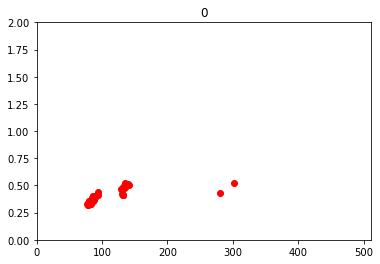

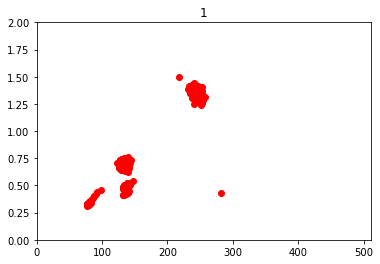

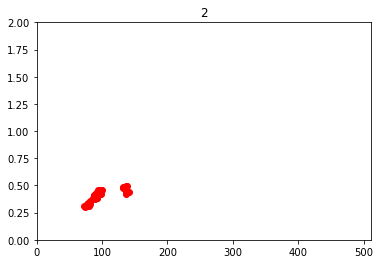

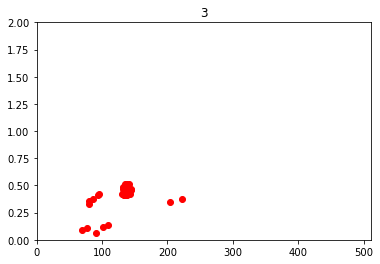

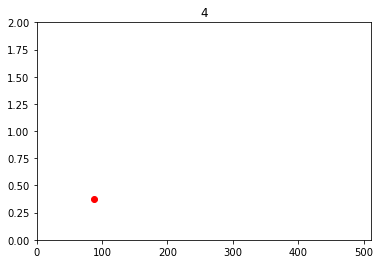

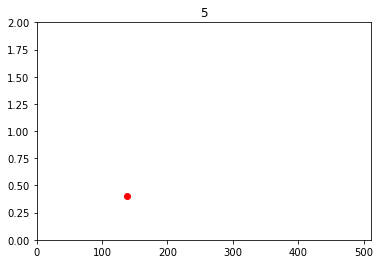

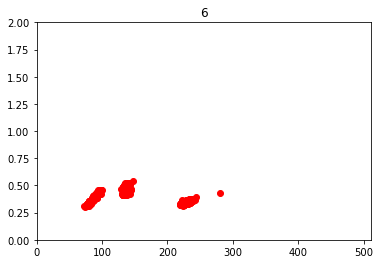

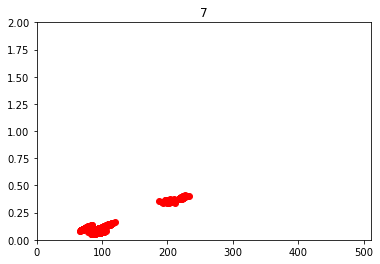

In [19]:
import matplotlib.pyplot as plt
plt.cla()
plt.clf()
plt.close()
for i in range(0, 8):
    for target in gt_targets:
        # plt.title(target['file'])
        #print('标注目标尺寸：', np.sort(target['obj_sizes']))
        #print('标注目标宽高比：', np.sort(target['obj_wh_ratios']))
        plt.plot(target['gt_sizes'][i], target['gt_wh_ratios'][i], 'ro')
        #plt.plot(target['obj_sizes'], target['obj_wh_ratios'], 'go')
        plt.axis([0, 512, 0, 2])
    plt.title(i)
    plt.show()


# 目标检测数据

对数据集，如验证集（val）、测试集（test）等都可以，每张图片检测后把结果收集。

检测结果：类别、ROIS、目标框面积、宽高比、掩码面积、面积比、得分

In [2]:
import time
config.RPN_ANCHOR_RATIOS = [1, 1, 1]
#config.RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  #调整检测使用的参数
config.RPN_ANCHOR_SCALES = (0, 0, 0, 300, 0)  #调整检测使用的参数
model = modellib.MaskRCNN(mode="inference", config=config,
                                model_dir="D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\\")
model.load_weights("D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\logs\mask20201217T2051\mask_rcnn_mask_0500.h5", by_name=True)
#detect_targets = []
for image_id in dataset_val.image_ids:
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    # print(gt_box)
    start_time = time.time()
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    end_time = time.time()
    print("Time: %s" % str(end_time - start_time))
    # print(results)
    r = results[0]
    target = [x for x in gt_targets if x['file'] == dataset_val.image_reference(image_id)]
    '''
    target = {
        'file' : dataset_val.image_reference(image_id),
        'objs' : []
    }
    '''
    print(dataset_val.image_reference(image_id))
    for i in range(0,len(r['class_ids'])):
        box_height = r['rois'][i][2] - r['rois'][i][0]
        box_width = r['rois'][i][3] - r['rois'][i][1]
        box_area = box_height * box_width
        box_ratio = box_width / box_height
        mask_area = np.sum(r['masks'][:,:,i]==True)
        mask_ratio = mask_area / box_area
        obj = {
            'class_id' : r['class_ids'][i],
            'bbox' : r['rois'][i],
            'bbox_area' : box_area,
            'wh_ratio' : box_ratio,
            'mask_area' : mask_area,
            'mask_ratio' : mask_ratio,
            'score' : r['scores'][i],
            'size' : (obj['bbox'][3] - obj['bbox'][1]) / math.sqrt(obj['wh_ratio'])
        }
        target[0]['objs'].append(obj)
        print(r['class_ids'][i], r['rois'][i], box_area, box_ratio, mask_area, mask_ratio, r['scores'][i])
#    detect_targets.append(target)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 500
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 5.642182111740112
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00288.jpeg
7 [ 334  784  722 1024] 93120 0.6185567010309279 58524 0.628479381443299 0.9999906
7 [341  10 716 208] 74250 0.528 50382 0.6785454545454546 0.997717
4 [258  23 546 331] 88704 1.0694444444444444 9630 0.1085633116883117 0.99577135
4 [ 241  635  538 1024] 115533 1.3097643097643097 10691 0.09253633161088173 0.944712
Processing 1 images
image                    

Time: 0.31389784812927246
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00298.jpeg
7 [ 337  788  717 1024] 89680 0.6210526315789474 57268 0.6385816235504014 0.99998593
4 [257  18 557 308] 87000 0.9666666666666667 10104 0.11613793103448276 0.9990325
7 [342  14 737 200] 73470 0.4708860759493671 50747 0.690717299578059 0.9868863
4 [ 240  615  554 1024] 128426 1.302547770700637 9937 0.07737529783688661 0.94310004
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3089005947113037
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00299.jpeg
7 [ 335  780  715 1024] 92720 0.6421052631578947 57454 0.6196505608283003 0.999

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3168981075286865
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00311.jpeg
7 [ 335  789  720 1024] 90475 0.6103896103896104 59093 0.6531417518651561 0.9999691
4 [ 246  604  556 1024] 130200 1.3548387096774193 8535 0.06555299539170507 0.9985318
4 [264  22 546 326] 85728 1.0780141843971631 9416 0.10983575961179545 0.9979153
7 [342   6 709 207] 73767 0.547683923705722 50602 0.6859706915016199 0.9902221
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0

Time: 0.3108992576599121
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00323.jpeg
7 [ 335  791  727 1024] 91336 0.5943877551020408 58860 0.6444337391609004 0.99999
4 [260  22 547 330] 88396 1.0731707317073171 9919 0.11221095977193538 0.9985663
4 [ 234  683  554 1018] 107200 1.046875 8575 0.07999067164179105 0.9977921
7 [350   8 745 191] 72285 0.46329113924050636 51883 0.7177561043093311 0.9752059
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3148994445800781
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00324.jpeg
7 [ 336  789  726 1024] 91650 0.6025641025641025 58925 0.6429350791052919 0.99998856
4 [260 

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.31689906120300293
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00335.jpeg
7 [ 340  786  725 1024] 91630 0.6181818181818182 58659 0.6401724326094074 0.99999046
4 [ 245  662  563 1024] 115116 1.1383647798742138 9206 0.07997150700163314 0.9993394
4 [269  17 549 328] 87080 1.1107142857142858 10139 0.11643316490583372 0.99869436
7 [339  17 736 200] 72651 0.4609571788413098 49446 0.6805962753437668 0.9973423
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.314896821975708
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00346.jpeg
7 [ 336  782  724 1024] 93896 0.6237113402061856 57892 0.6165544858140922 0.99999344
4 [266  21 548 319] 84036 1.0567375886524824 9868 0.117425865105431 0.9986872
7 [336  10 724 211] 77988 0.5180412371134021 50356 0.6456890803713392 0.99685955
4 [ 252  607  539 1019] 118244 1.4355400696864111 9468 0.08007171611244546 0.9915071
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.31389904022216797
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00357.jpeg
7 [ 333  788  719 1024] 91096 0.6113989637305699 59518 0.6533547027311847 0.9999865
4 [ 251  646  556 1024] 115290 1.2393442622950819 9828 0.08524590163934426 0.99913967
4 [269  19 547 311] 81176 1.0503597122302157 10664 0.13136887750073914 0.99870336
7 [326  10 760 196] 80724 0.42857142857142855 52845 0.6546380258659135 0.9974953
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.32189297676086426
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00287.jpeg
7 [ 332  791  716 1024] 89472 0.6067708333333334 59064 0.6601394849785408 0.9999856
7 [341   9 716 209] 75000 0.5333333333333333 50112 0.66816 0.9980819
4 [259  22 549 332] 89900 1.0689655172413792 9579 0.10655172413793103 0.99584633
4 [ 238  626  556 1024] 126564 1.251572327044025 10825 0.0855298505104137 0.9555748
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  m

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3178975582122803
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00008.jpeg
4 [ 257  656  555 1013] 106386 1.1979865771812082 11719 0.11015547158460699 0.99999726
7 [ 333  787  737 1024] 95748 0.5866336633663366 61611 0.6434703596941973 0.9997873
4 [264  27 552 328] 86688 1.0451388888888888 9817 0.11324520118124769 0.995193
3 [303 664 651 800] 47328 0.39080459770114945 7325 0.1547709601081812 0.96849895
7 [323  20 727 215] 78780 0.48267326732673266 49036 0.6224422442244224 0.9381162
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  ma

Time: 0.32689476013183594
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00017.jpeg
4 [ 252  664  550 1013] 104002 1.1711409395973154 11062 0.1063633391665545 0.9999753
7 [ 304  791  756 1024] 105316 0.5154867256637168 60708 0.5764366288123363 0.9999571
4 [260  23 563 326] 91809 1.0 10239 0.11152501388752736 0.99314123
7 [331  20 735 211] 77164 0.47277227722772275 48962 0.6345186874708413 0.9697178
3 [321 658 644 792] 43282 0.4148606811145511 5193 0.11998059239406682 0.9361006
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.310901403427124
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00018.jpeg
7 [ 316  797

Time: 0.3129005432128906
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\scene00027.jpeg
4 [ 253  660  528 1002] 94050 1.2436363636363637 12118 0.12884635832004254 0.99999404
7 [ 311  798  746 1024] 98310 0.5195402298850574 61323 0.6237717424473604 0.9998882
4 [259  19 568 330] 96099 1.006472491909385 10314 0.10732681921768177 0.9909095
7 [337  18 739 215] 79194 0.4900497512437811 49231 0.6216506300982397 0.95744485
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3009033203125
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00001.jpeg
1 [586 644 791 918] 56170 1.3365853658536586 32687 0.5819298557949083 0.99

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.2828865051269531
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00013.jpeg
1 [587 644 792 919] 56375 1.3414634146341464 33033 0.5859512195121951 0.9996698
1 [577  90 791 376] 61204 1.3364485981308412 33478 0.5469903927847853 0.9980903
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (

Time: 0.30590128898620605
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00025.jpeg
1 [584 646 791 922] 57132 1.3333333333333333 32655 0.5715710985087167 0.99960417
1 [574  88 791 376] 62496 1.327188940092166 33469 0.5355382744495648 0.99852246
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29990267753601074
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00026.jpeg
1 [583 647 791 922] 57200 1.3221153846153846 32738 0.5723426573426573 0.9995678
1 [581  91 791 377] 60060 1.361904761904762 33887 0.5642191142191142 0.999514
Processing 1 images
image                    shape: (1024, 1024, 3)      

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.301877498626709
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00039.jpeg
1 [590 646 791 919] 54873 1.3582089552238805 32395 0.5903632023035008 0.99966204
1 [571  86 791 375] 63580 1.3136363636363637 33735 0.5305913809374017 0.9990313
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (

Time: 0.3099019527435303
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00051.jpeg
1 [575  84 789 378] 62916 1.3738317757009346 33435 0.5314228495136373 0.9988236
1 [591 661 793 919] 52116 1.2772277227722773 32389 0.6214790083659528 0.9420769
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.30789971351623535
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00052.jpeg
1 [574  84 789 377] 62995 1.3627906976744186 33364 0.5296293356615605 0.99854076
1 [592 661 793 920] 52059 1.2885572139303483 32352 0.621448740851726 0.9443434
Processing 1 images
image                    shape: (1024, 1024, 3)      

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29990339279174805
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00064.jpeg
1 [584 644 793 922] 58102 1.3301435406698565 32981 0.5676396681697704 0.9994086
1 [567  84 789 370] 63492 1.2882882882882882 33876 0.5335475335475336 0.99925107
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape:

Time: 0.295881986618042
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00076.jpeg
1 [571  88 790 377] 63291 1.3196347031963471 34213 0.5405665892464964 0.9996493
1 [581 646 794 921] 58575 1.2910798122065728 33399 0.570192061459667 0.999509
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.3029041290283203
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00077.jpeg
1 [570  87 789 374] 62853 1.3105022831050228 33938 0.5399583154344264 0.99962974
1 [580 646 793 922] 58788 1.295774647887324 33381 0.5678199632578077 0.9995049
Processing 1 images
image                    shape: (1024, 1024, 3)       min

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29990625381469727
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00089.jpeg
1 [575  97 794 391] 64386 1.3424657534246576 35246 0.5474171403721306 0.99996054
1 [581 644 795 920] 59064 1.2897196261682242 33122 0.5607815251252878 0.99943644
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape

Time: 0.29790401458740234
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00101.jpeg
1 [581 644 795 919] 58850 1.2850467289719627 33019 0.5610705182667799 0.99940836
1 [570  92 798 394] 68856 1.3245614035087718 34761 0.5048361798536075 0.9951062
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.30390429496765137
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00102.jpeg
1 [581 644 795 920] 59064 1.2897196261682242 33231 0.5626269809020723 0.9994349
1 [569  91 798 394] 69387 1.3231441048034935 34930 0.5034084194445645 0.9950486
Processing 1 images
image                    shape: (1024, 1024, 3)    

Time: 0.30989909172058105
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00115.jpeg
1 [568  91 789 376] 62985 1.2895927601809956 34047 0.5405572755417957 0.99906427
1 [580 644 797 919] 59675 1.2672811059907834 32957 0.5522748219522413 0.99904996
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29590559005737305
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00116.jpeg
1 [569  89 788 378] 63291 1.3196347031963471 33680 0.5321451707193756 0.9989436
1 [579 668 797 934] 57988 1.2201834862385321 31558 0.5442160446989032 0.96759665
Processing 1 images
image                    shape: (1024, 1024, 3)  

Time: 0.2989039421081543
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00127.jpeg
1 [570  92 792 377] 63270 1.2837837837837838 34670 0.5479690216532321 0.9985857
1 [580 670 798 933] 57334 1.2064220183486238 31447 0.5484878082812991 0.9558178
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.30190205574035645
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00128.jpeg
1 [571  92 793 376] 63048 1.2792792792792793 34841 0.5526107093008501 0.99840456
1 [580 671 799 934] 57597 1.2009132420091324 31352 0.544333906279841 0.9506578
Processing 1 images
image                    shape: (1024, 1024, 3)      

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.27690958976745605
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00140.jpeg
1 [572  89 789 377] 62496 1.327188940092166 33584 0.5373783922171019 0.999116
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.2929058074

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.2989006042480469
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00154.jpeg
1 [585 642 796 918] 58236 1.3080568720379147 32722 0.5618861185520984 0.9991787
1 [570  93 792 371] 61716 1.2522522522522523 34256 0.5550586557780802 0.9989201
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.2819099426269531
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00166.jpeg
1 [582 642 797 917] 59125 1.2790697674418605 32890 0.5562790697674419 0.999012
1 [572  85 794 376] 64602 1.3108108108108107 34086 0.5276307235070121 0.9977404
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29590344429016113
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00179.jpeg
1 [571  89 792 373] 62764 1.2850678733031675 33970 0.5412338283092218 0.9990996
1 [582 661 799 925] 57288 1.2165898617511521 32450 0.5664362519201229 0.9410432
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: 

Time: 0.2909057140350342
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00192.jpeg
1 [570  89 791 373] 62764 1.2850678733031675 33837 0.5391147791727742 0.99921155
1 [582 659 797 927] 57620 1.2465116279069768 32577 0.5653766053453662 0.9137825
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 20)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.14663  max:    1.11535  float32
Time: 0.29190659523010254
D:\Projects\Mask_RCNN\my_mask_rcnn\dataset_1119\train\20201123scene00193.jpeg
1 [570  89 791 373] 62764 1.2850678733031675 33800 0.5385252692626347 0.9992298
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 10

# 目标框

计算GT的bbox与检测的bbox的IoU。

2个目标怎么匹配？IoU最大的那个

[58524, 50382, 9630, 10691]
[62662, 55950, 10950, 12202]
[7, 7, 4, 4]
[58492, 50142, 9647, 9918]
[60805, 55105, 10866, 11628]
[7, 7, 4, 4]
[58988, 50112, 9933, 10276]
[61185, 54796, 11203, 12513]
[7, 7, 4, 4]
[59136, 49819, 9922, 9989]
[60756, 54949, 10417, 12887]
[7, 7, 4, 4]
[57951, 50009, 9990, 10380]
[60711, 54894, 12094, 11188]
[7, 7, 4, 4]
[59103, 50148, 9765, 10929]
[61099, 55726, 11878, 12643]
[7, 7, 4, 4]
[59341, 48469, 9913, 10125]
[60958, 54916, 11805, 11731]
[7, 7, 4, 4]
[58971, 10058, 48552, 10765]
[60294, 9461, 55093, 11077]
[7, 4, 7, 4]
[58956, 9807, 48766, 10061]
[60348, 9535, 54274, 10964]
[7, 4, 7, 4]
[57268, 10104, 50747, 9937]
[61307, 10730, 55179, 11253]
[7, 4, 7, 4]
[57454, 9595, 50585, 10293]
[60236, 11210, 54344, 12107]
[7, 4, 7, 4]
[57071, 9000, 50683]
[60773, 11514, 54775]
[7, 4, 7]
[57820, 9037, 51051]
[61238, 10843, 55123]
[7, 4, 7]
[57994, 8650, 50621, 10275]
[59828, 11535, 54919, 12795]
[7, 4, 7, 4]
[58150, 9114, 9918, 51058]
[61470, 10215, 12105, 56536]
[

c:\users\ps\anaconda3\envs\mask_rcnn\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[58931, 8679, 9615, 51149]
[61483, 12598, 11128, 56067]
[7, 4, 4, 7]
[59567, 9509, 51111, 9767]
[61478, 10952, 54870, 11599]
[7, 4, 7, 4]
[59566, 9683, 51084, 9539]
[60447, 11343, 54867, 11790]
[7, 4, 7, 4]
[58720, 9644, 51070, 9733]
[60667, 11139, 54448, 12481]
[7, 4, 7, 4]
[58453, 9607, 50676, 8884]
[61261, 10736, 54395, 13095]
[7, 4, 7, 4]
[58460, 9636, 50645, 8959]
[60708, 12086, 54802, 12257]
[7, 4, 7, 4]
[58979, 9790, 8007, 51665]
[60521, 12043, 12626, 54495]
[7, 4, 4, 7]
[58720, 9653, 53279]
[60832, 12435, 54719]
[7, 4, 7]
[59296, 9663, 8422, 51983]
[61833, 12330, 14082, 55252]
[7, 4, 4, 7]
[58860, 9919, 8575, 51883]
[61400, 12066, 13029, 54784]
[7, 4, 4, 7]
[58925, 9819, 52216, 8205]
[61449, 12338, 55665, 13355]
[7, 4, 7, 4]
[58087, 9803, 52446, 9541]
[63987, 13194, 58038, 14335]
[7, 4, 7, 4]
[58765, 9935, 9620, 52456]
[62731, 13415, 15535, 57966]
[7, 4, 4, 7]
[58471, 10053, 8693, 52229]
[64853, 14131, 15255, 59206]
[7, 4, 4, 7]
[58602, 9837, 50838, 9248]
[63828, 13806, 56646, 

[32674, 33967]
[35088, 36790]
[1, 1]
[32740, 33863]
[37141, 37108]
[1, 1]
[32767, 34367]
[36000, 36834]
[1, 1]
[34292, 33064]
[37263, 35544]
[1, 1]
[34259, 33193]
[36234, 35183]
[1, 1]
[34330, 32914]
[36618, 34827]
[1, 1]
[34014, 32926]
[37455, 33584]
[1, 1]
[33956, 33189]
[37395, 36247]
[1, 1]
[34275, 33295]
[36883, 34113]
[1, 1]
[34213, 33399]
[38135, 34638]
[1, 1]
[33938, 33381]
[37607, 34412]
[1, 1]
[33741, 33116]
[36114, 35379]
[1, 1]
[33634, 32948]
[37200, 35254]
[1, 1]
[33981, 33043]
[34413, 35437]
[1, 1]
[33787, 33068]
[37633, 34131]
[1, 1]
[33992, 33160]
[37074, 34734]
[1, 1]
[35129, 32990]
[37061, 35683]
[1, 1]
[34843, 32866]
[38213, 34916]
[1, 1]
[35002, 33114]
[37332, 34889]
[1, 1]
[35279, 33060]
[37386, 36975]
[1, 1]
[35425, 32946]
[36865, 34330]
[1, 1]
[35000, 33065]
[38363, 34424]
[1, 1]
[35246, 33122]
[36836, 34035]
[1, 1]
[35146, 33192]
[36383, 34441]
[1, 1]
[35324, 33081]
[37884, 36752]
[1, 1]
[35389, 33161]
[36659, 35208]
[1, 1]
[35479, 32497]
[37520, 35248]
[1, 1]
[

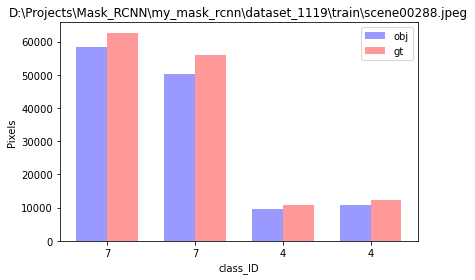

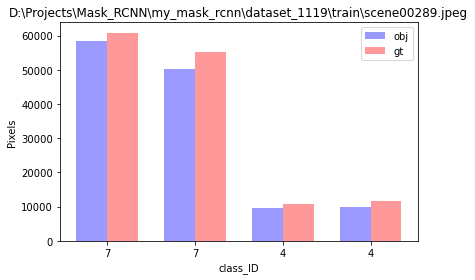

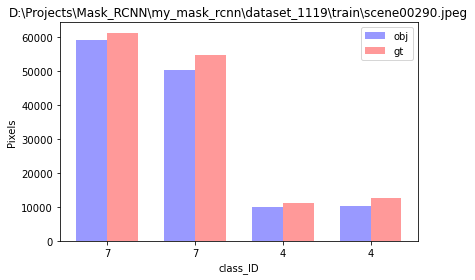

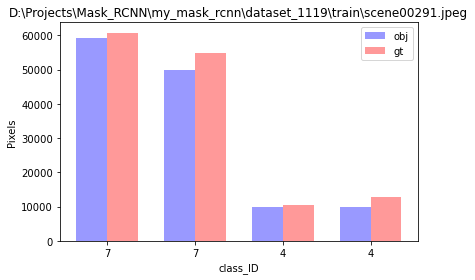

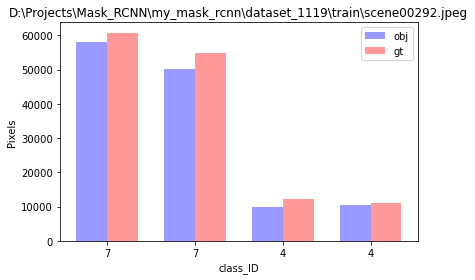

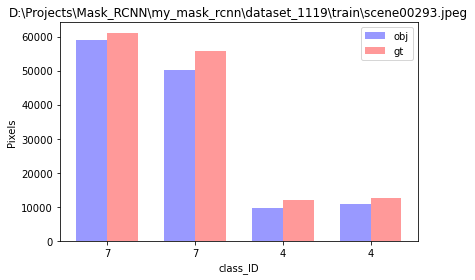

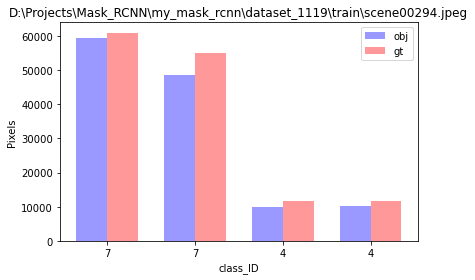

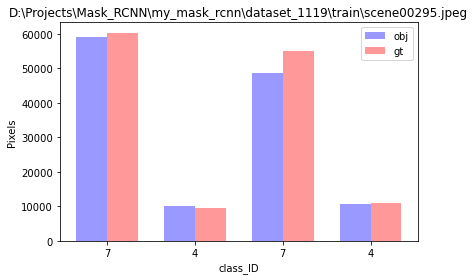

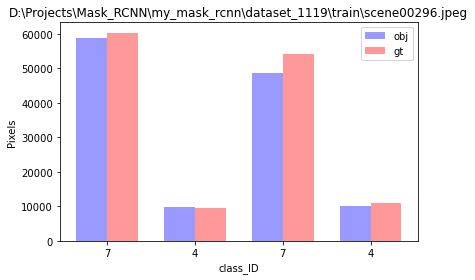

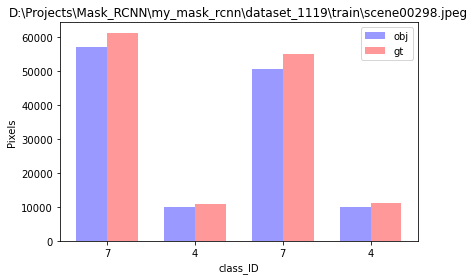

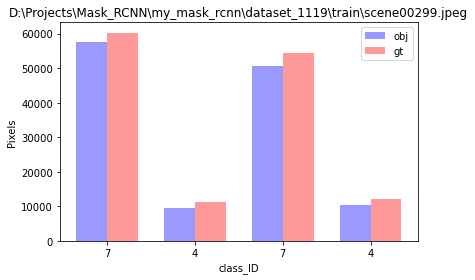

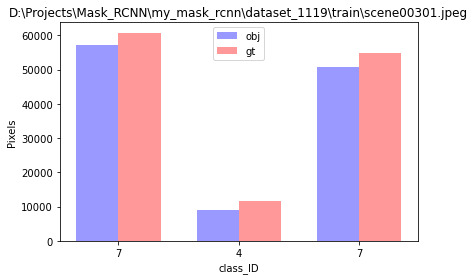

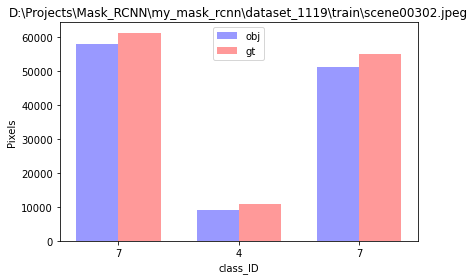

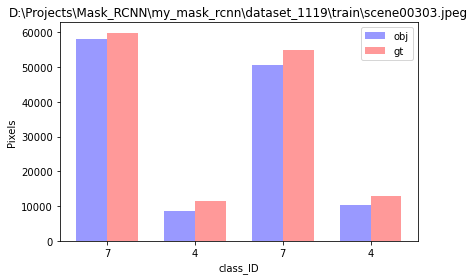

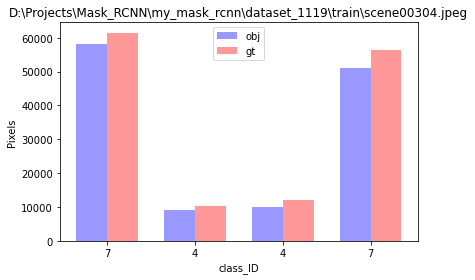

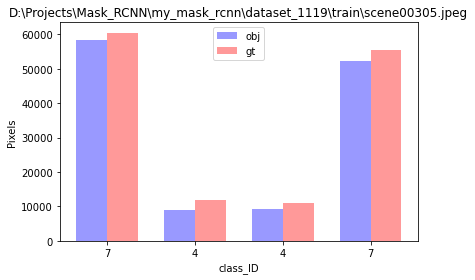

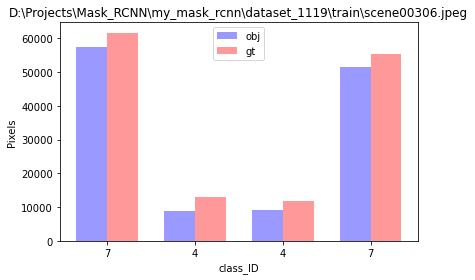

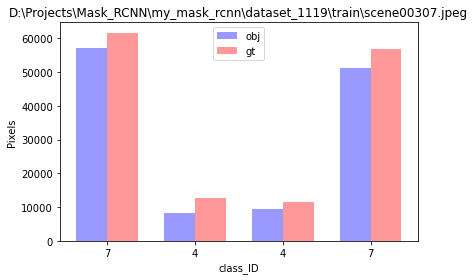

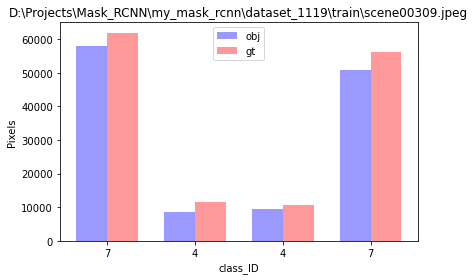

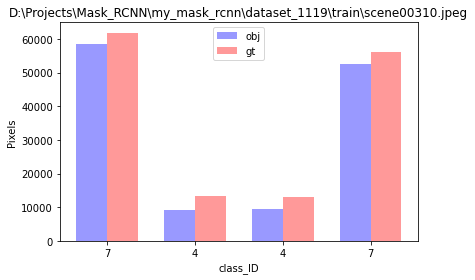

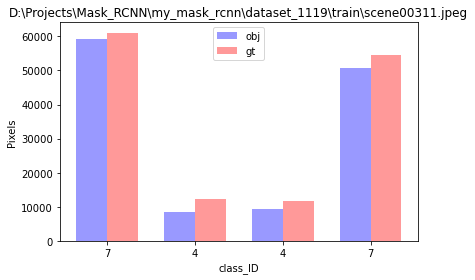

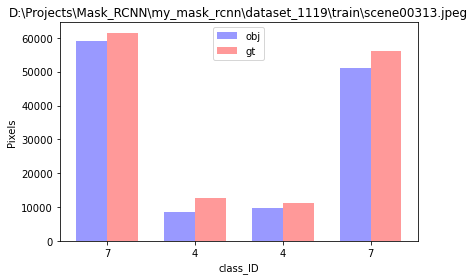

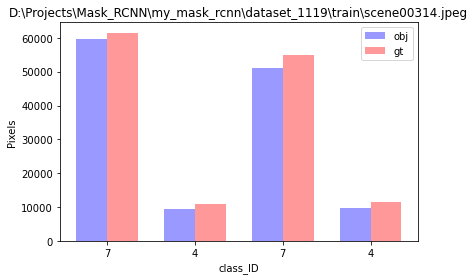

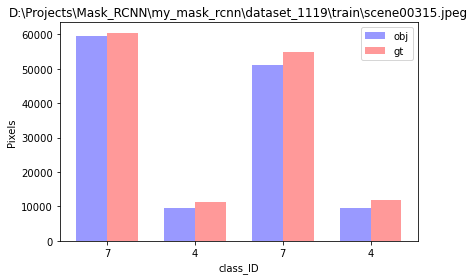

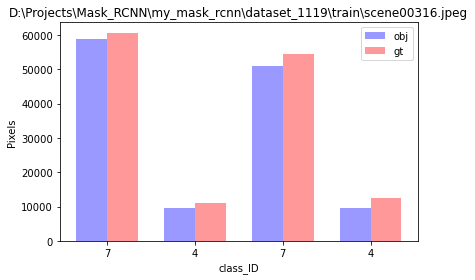

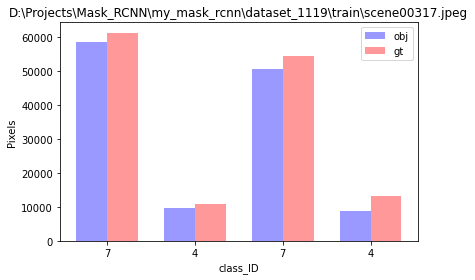

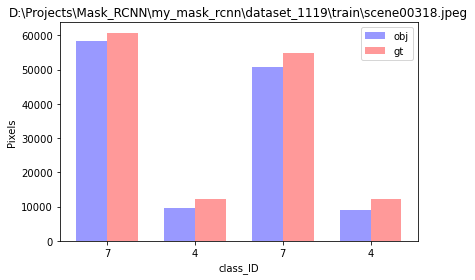

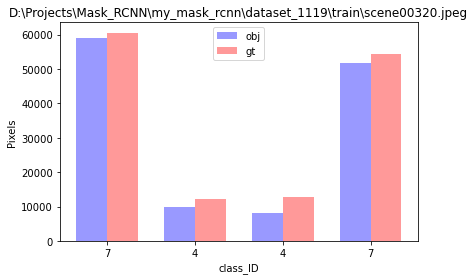

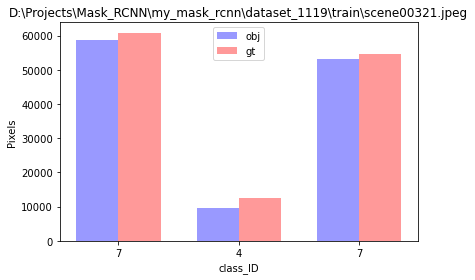

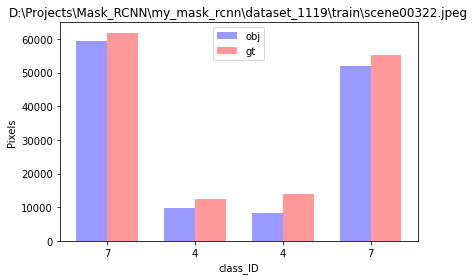

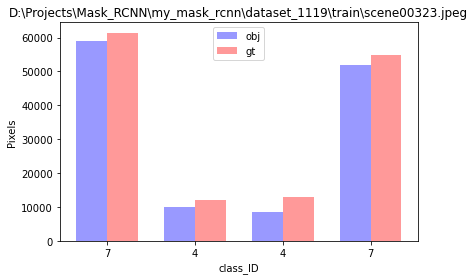

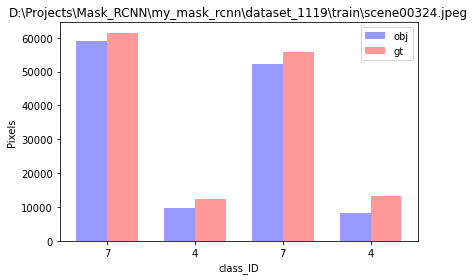

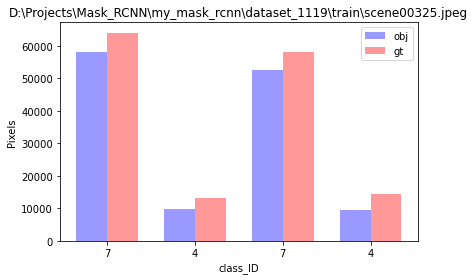

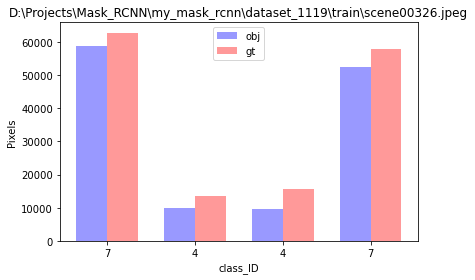

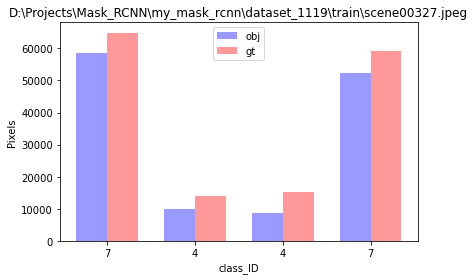

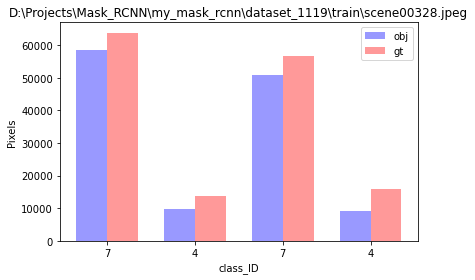

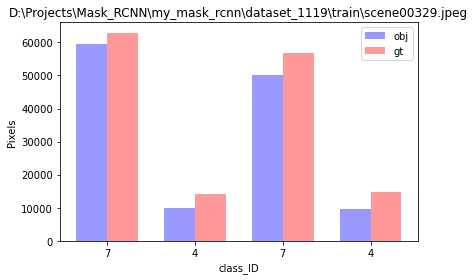

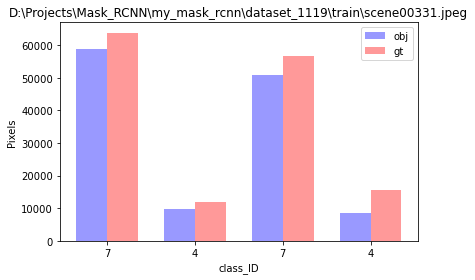

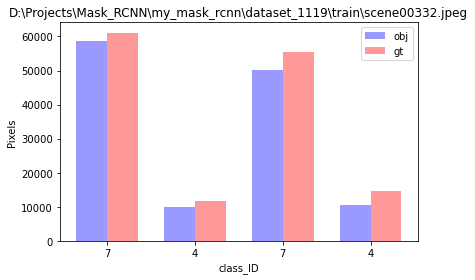

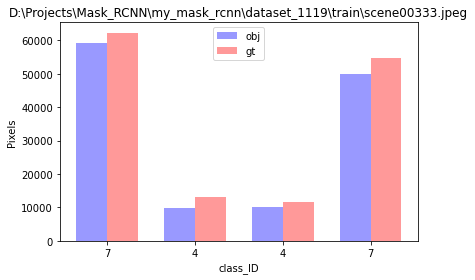

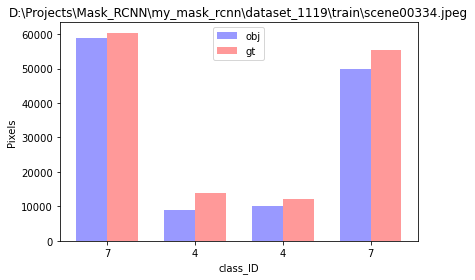

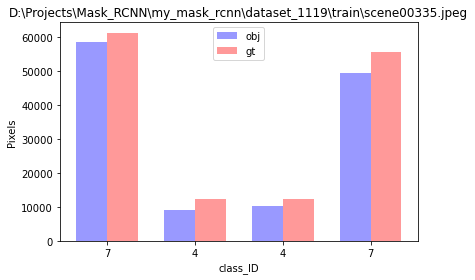

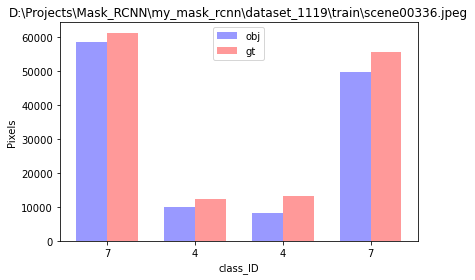

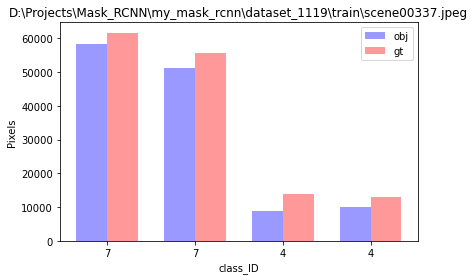

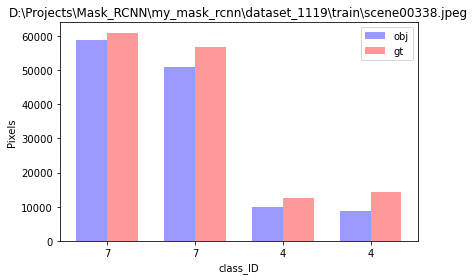

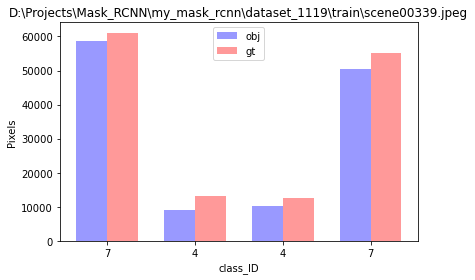

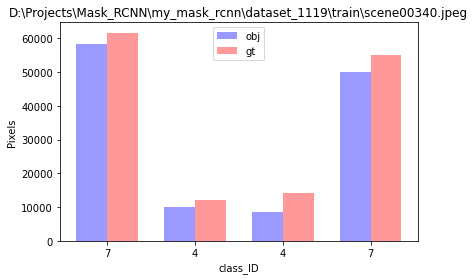

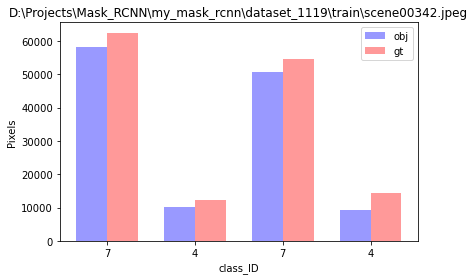

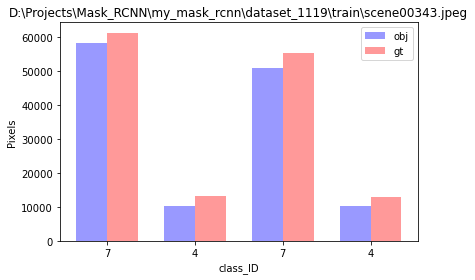

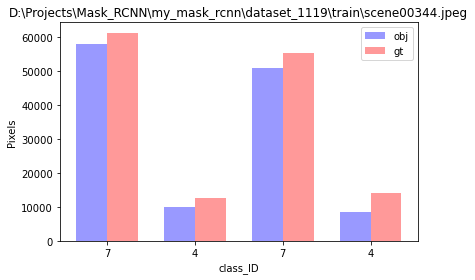

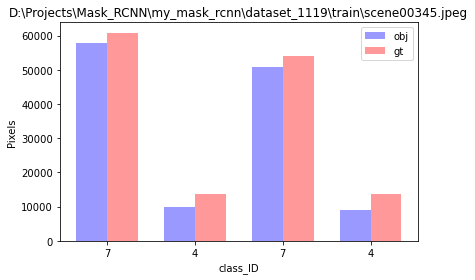

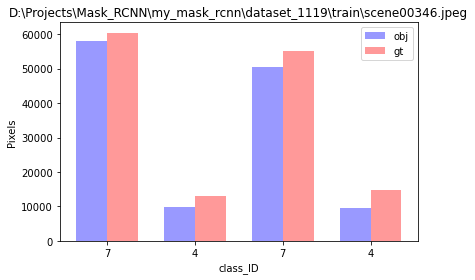

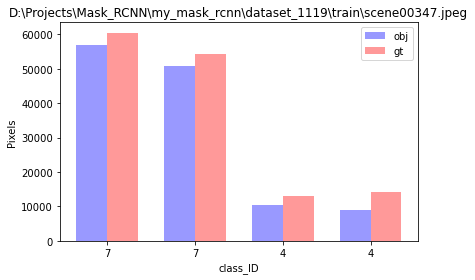

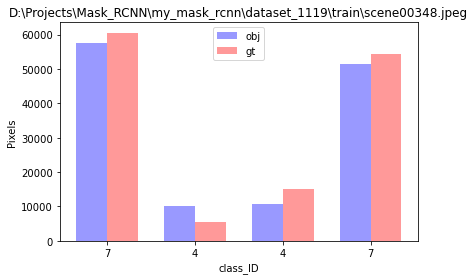

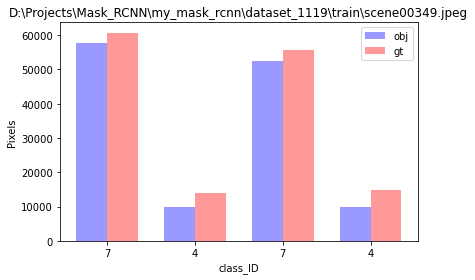

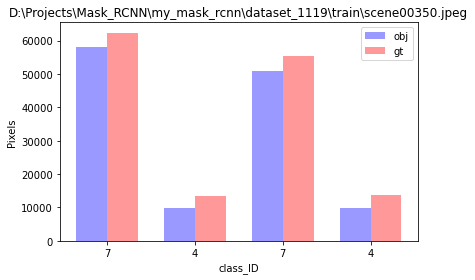

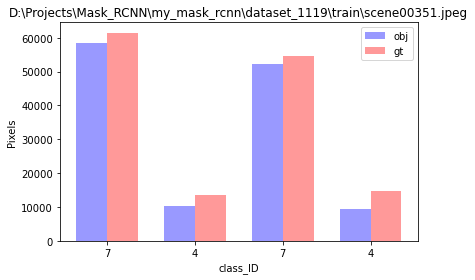

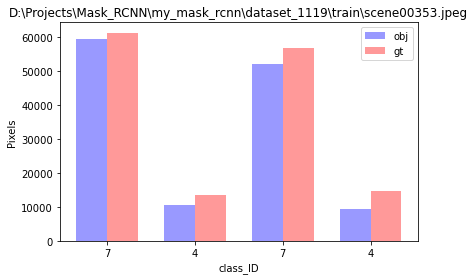

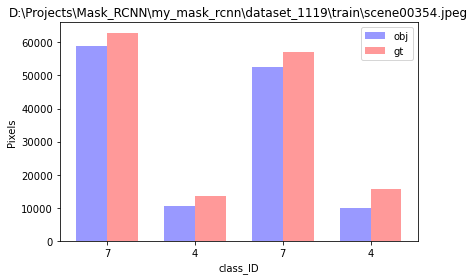

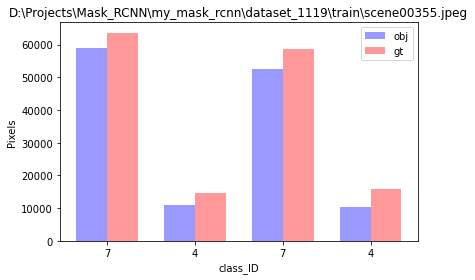

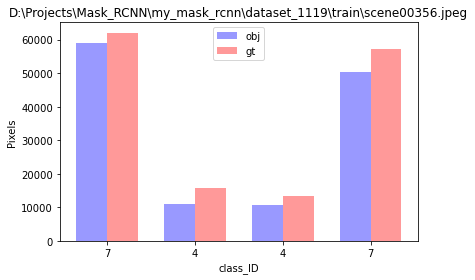

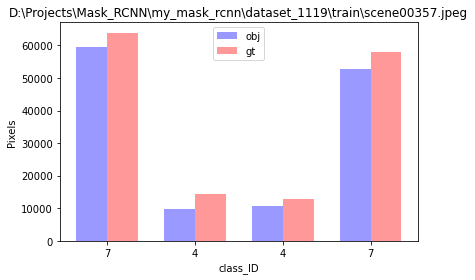

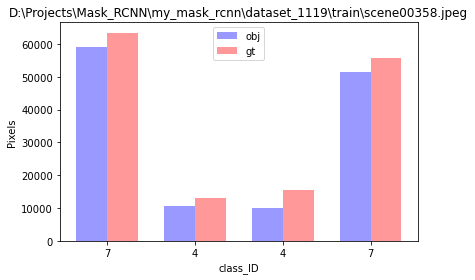

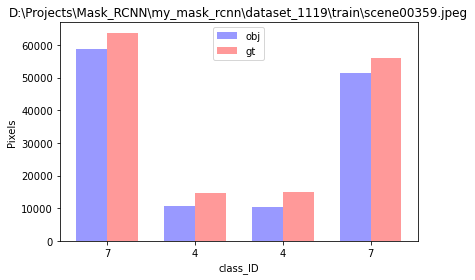

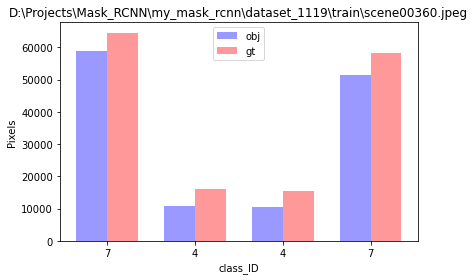

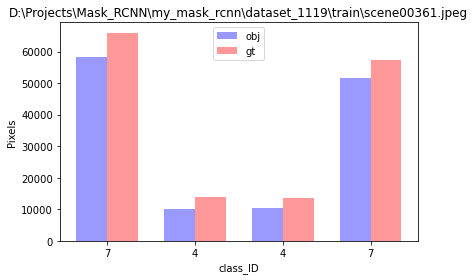

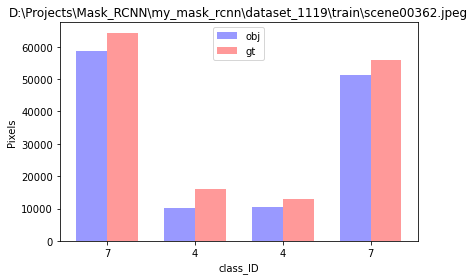

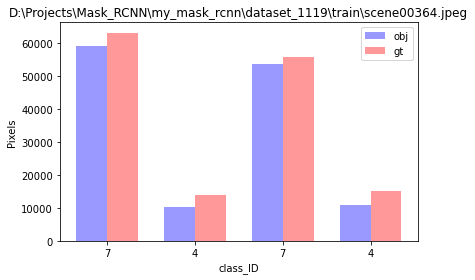

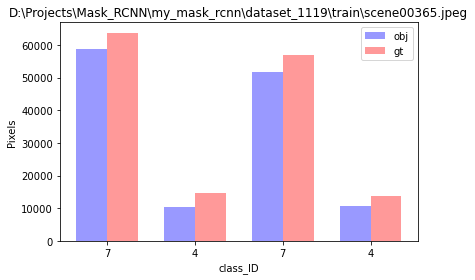

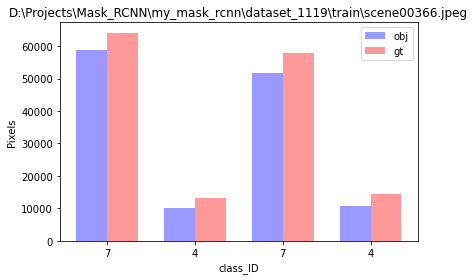

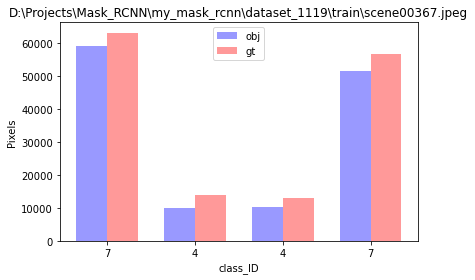

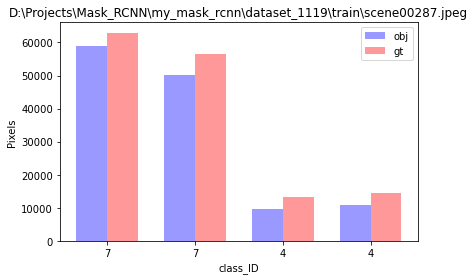

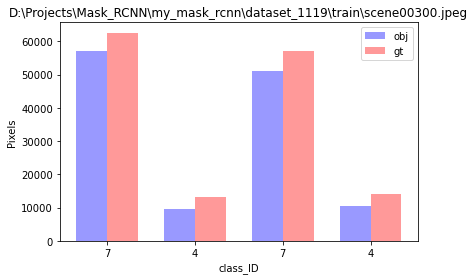

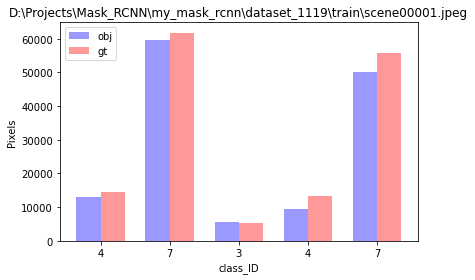

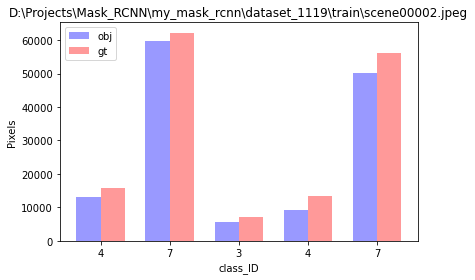

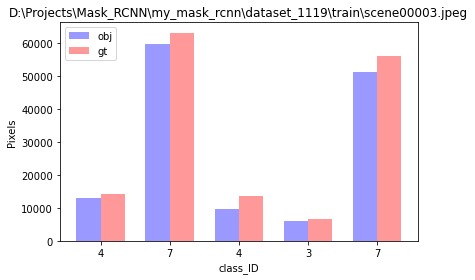

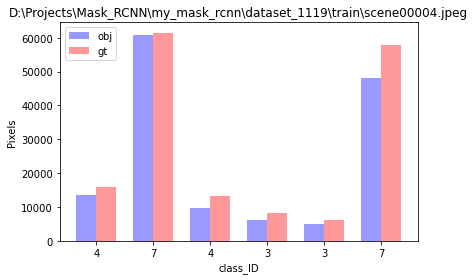

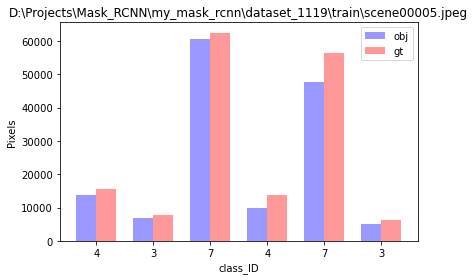

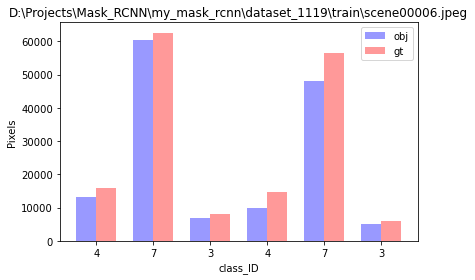

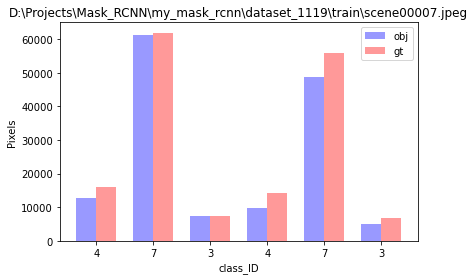

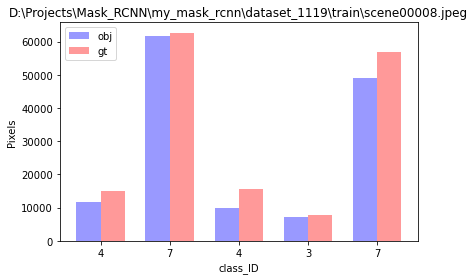

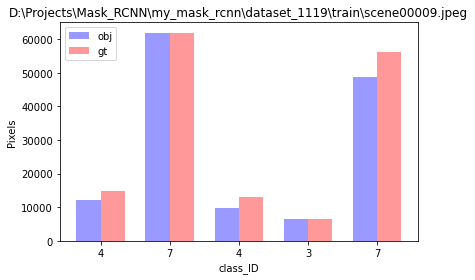

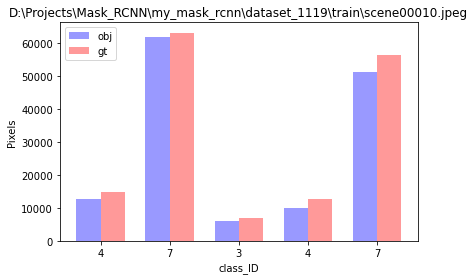

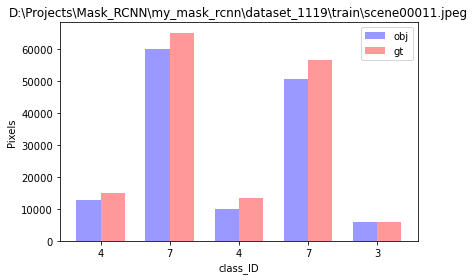

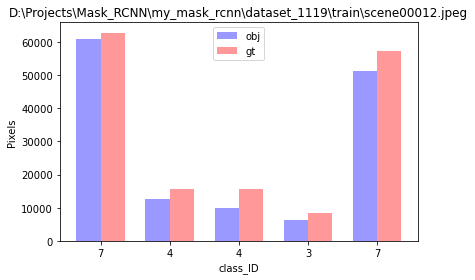

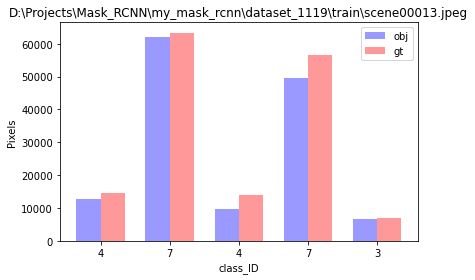

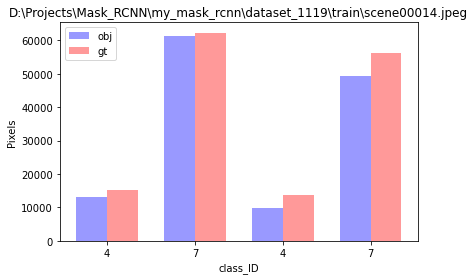

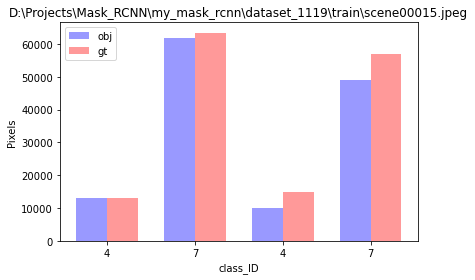

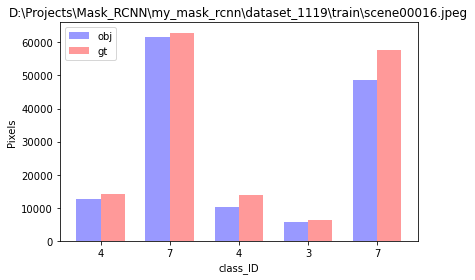

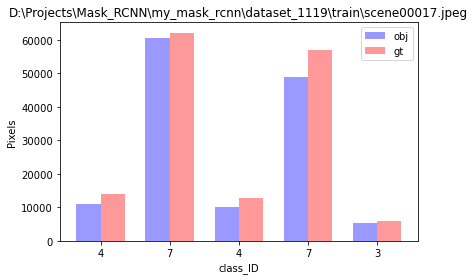

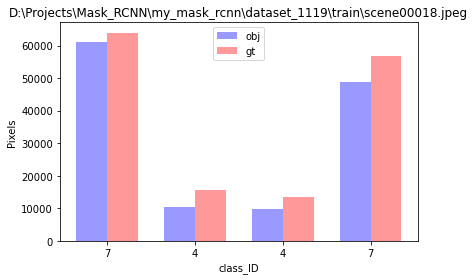

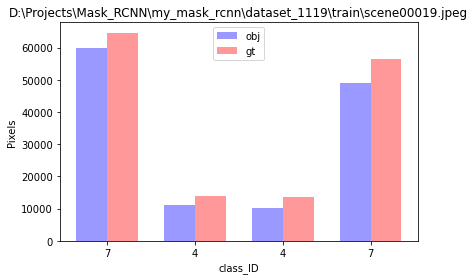

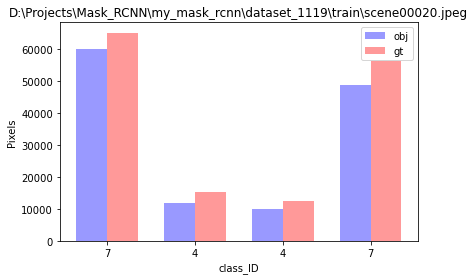

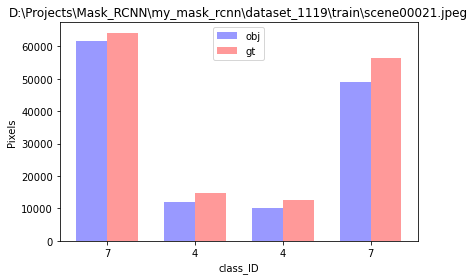

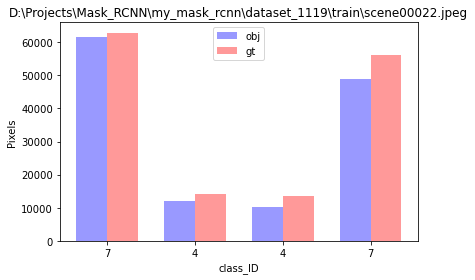

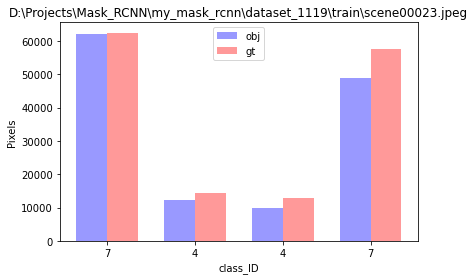

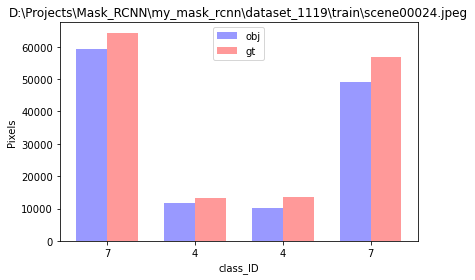

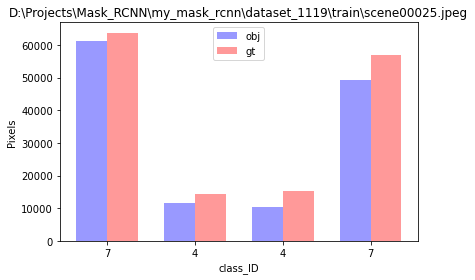

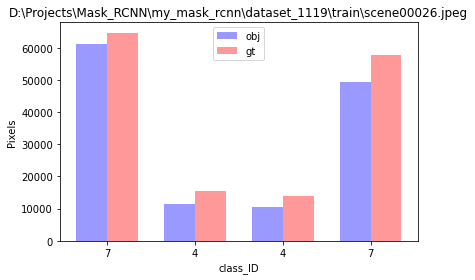

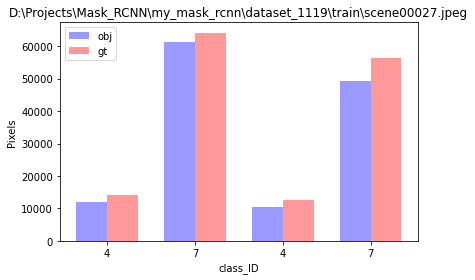

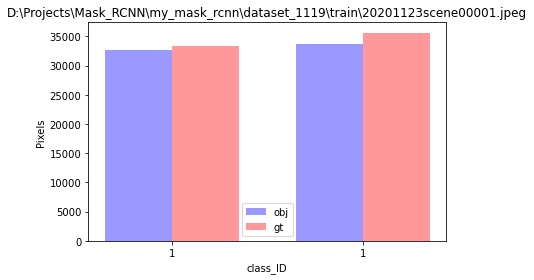

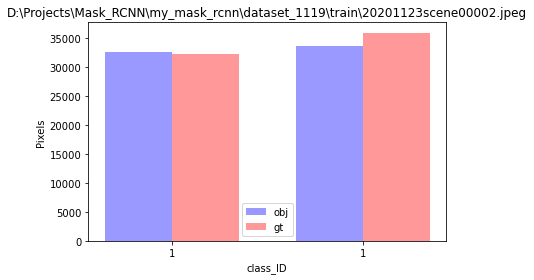

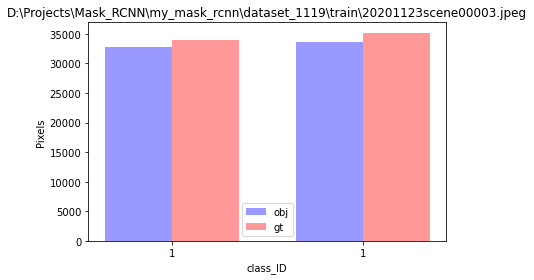

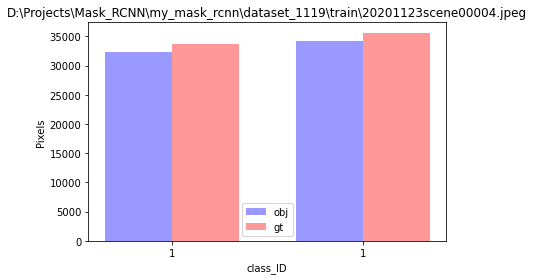

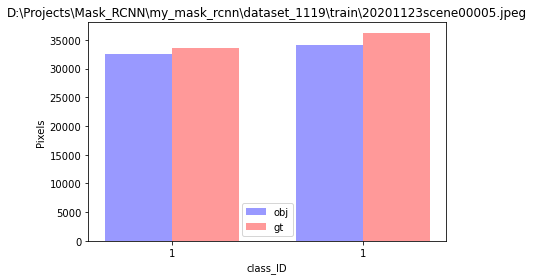

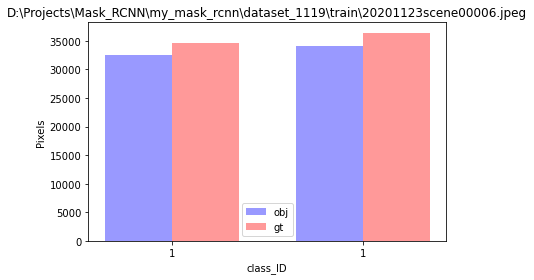

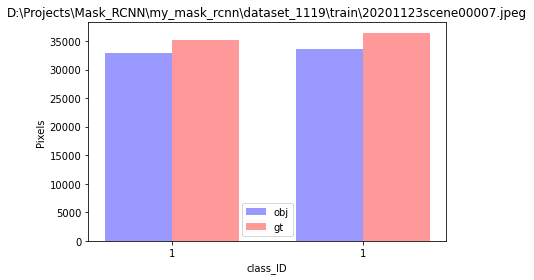

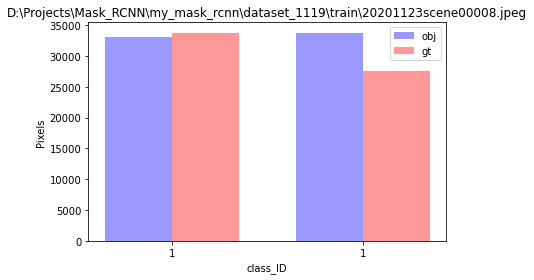

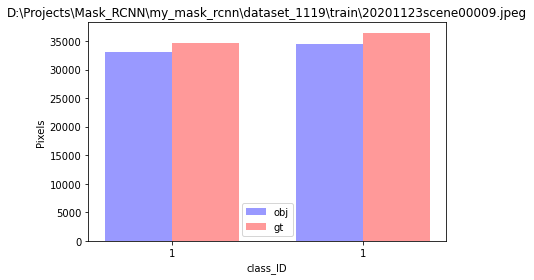

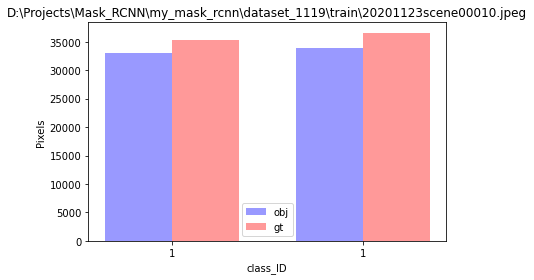

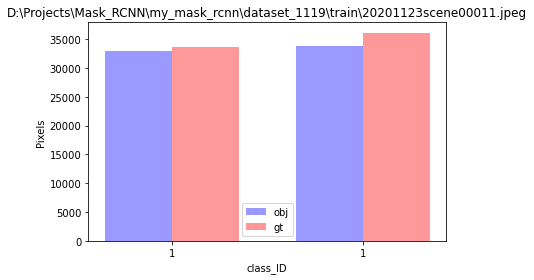

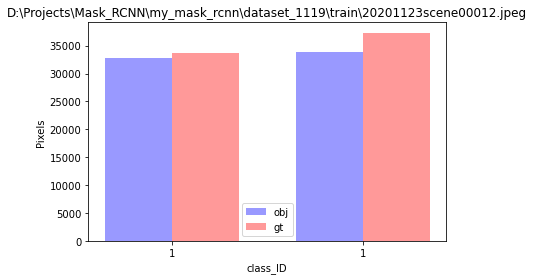

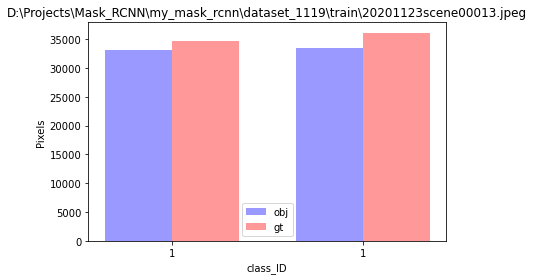

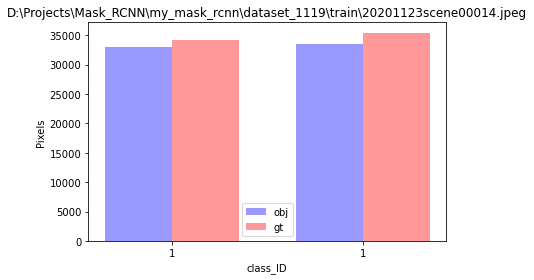

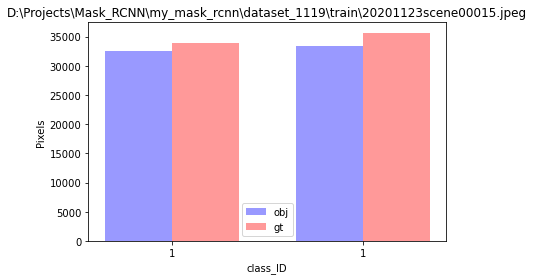

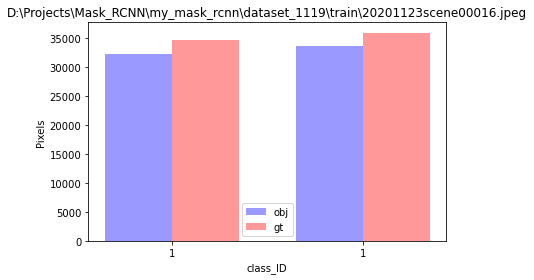

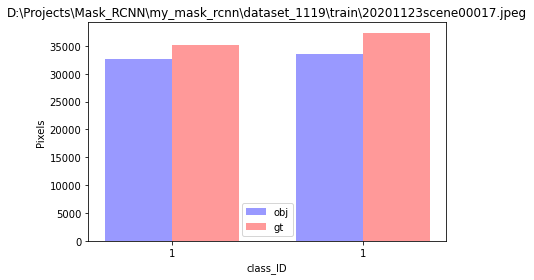

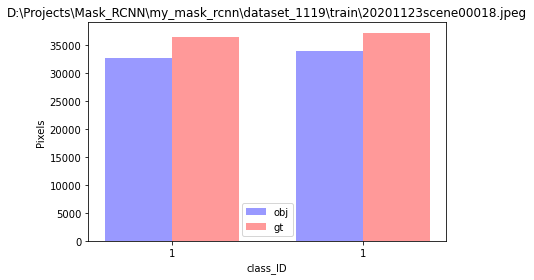

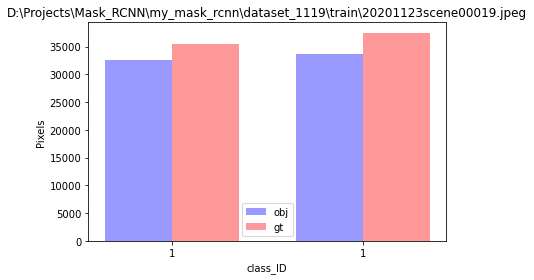

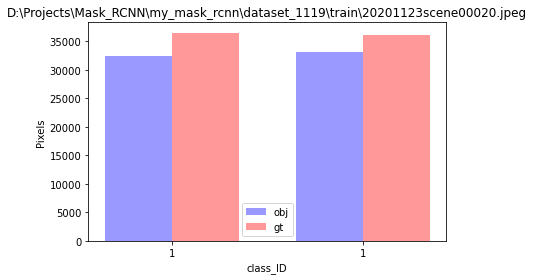

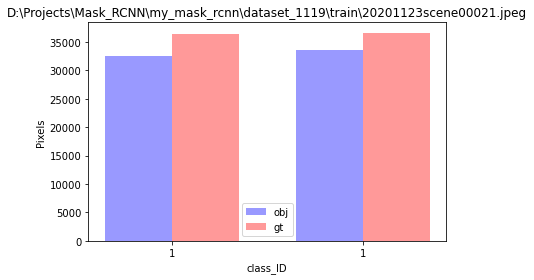

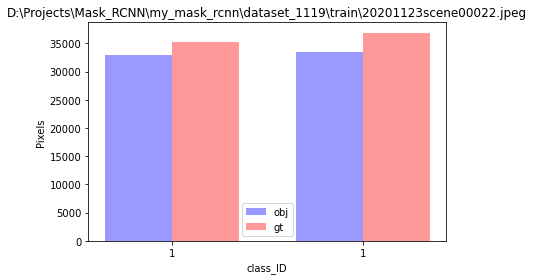

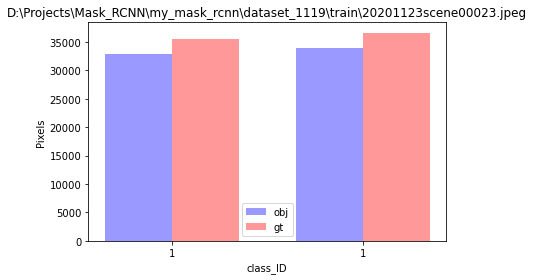

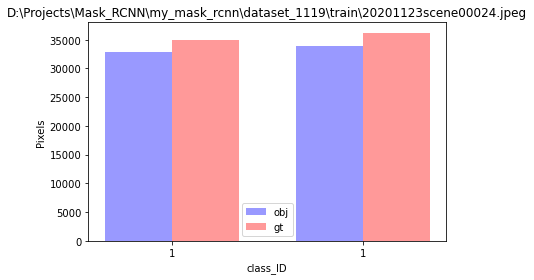

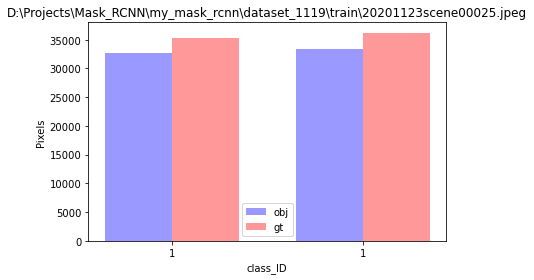

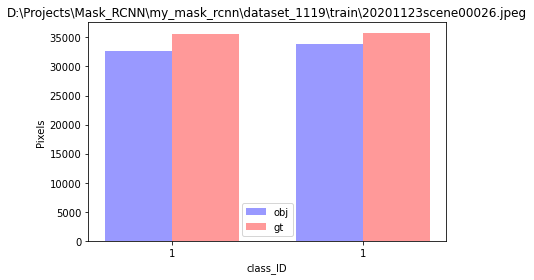

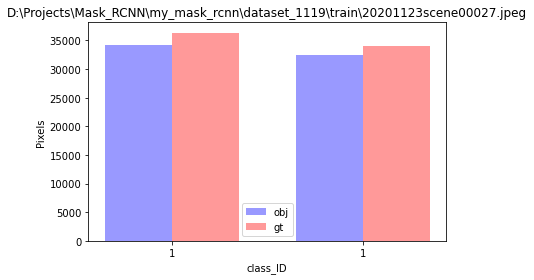

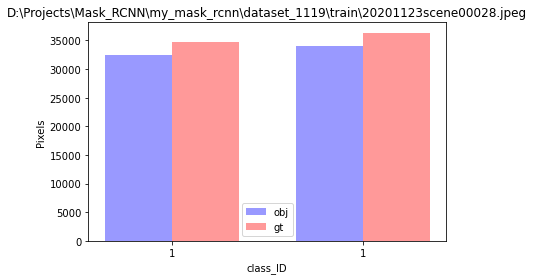

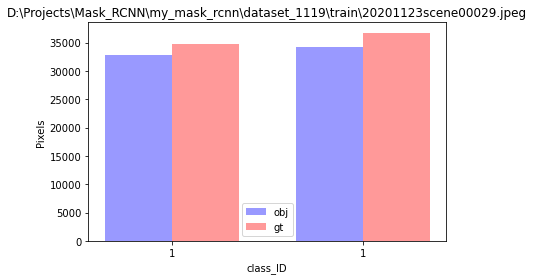

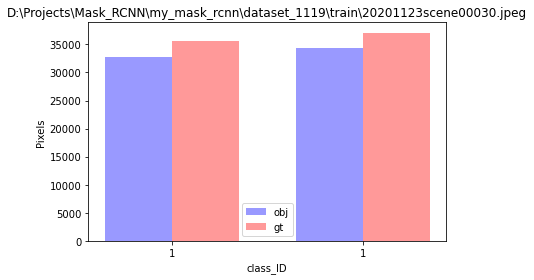

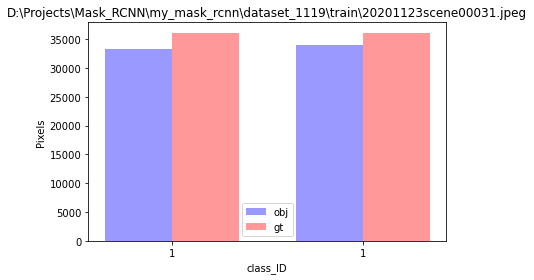

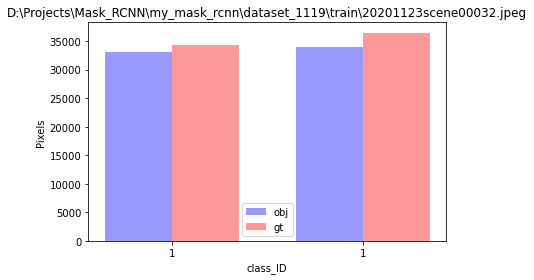

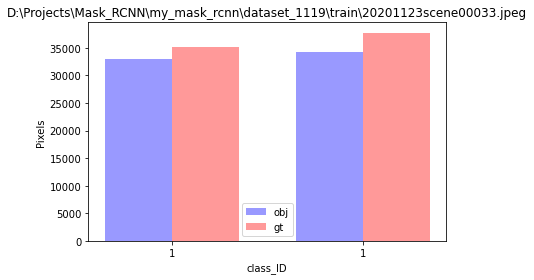

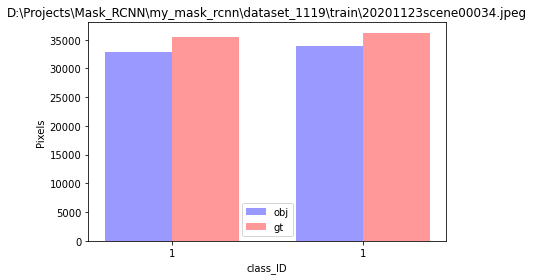

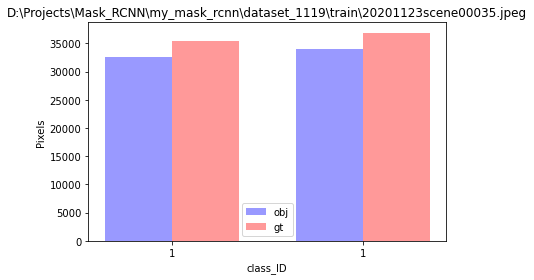

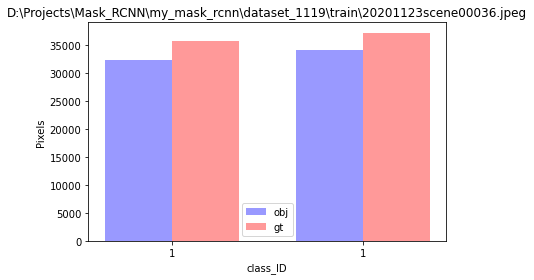

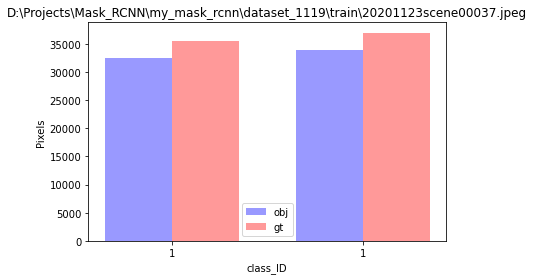

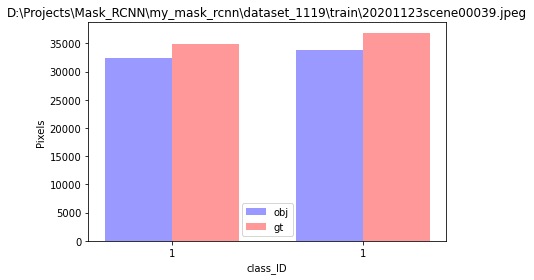

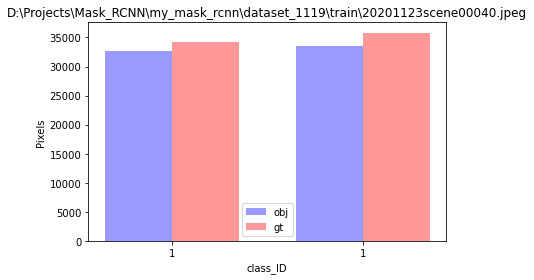

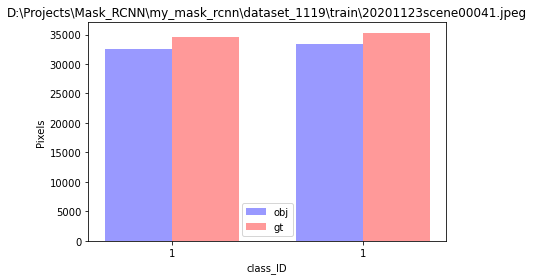

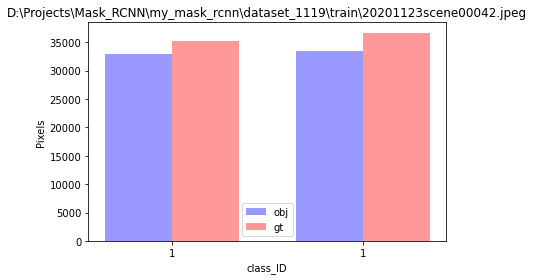

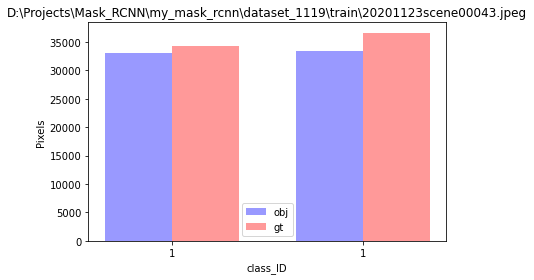

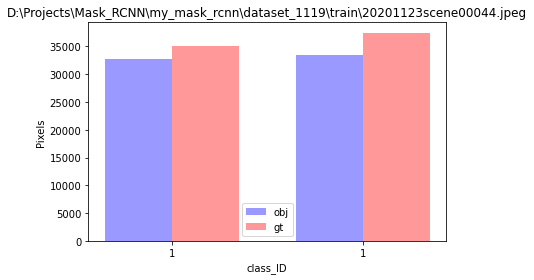

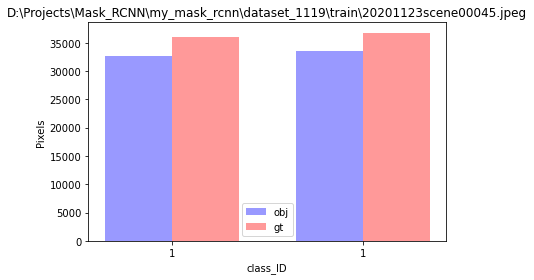

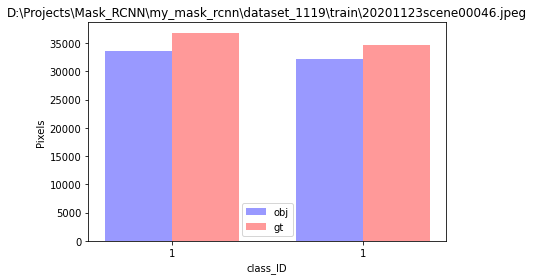

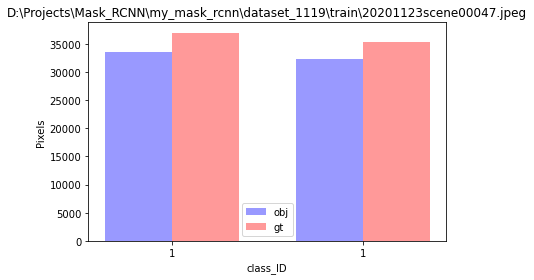

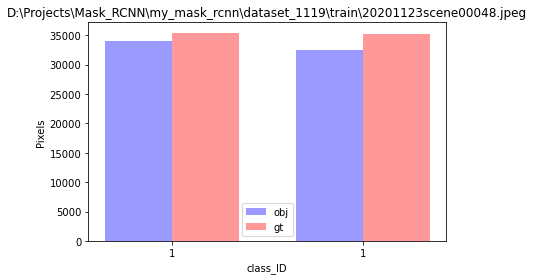

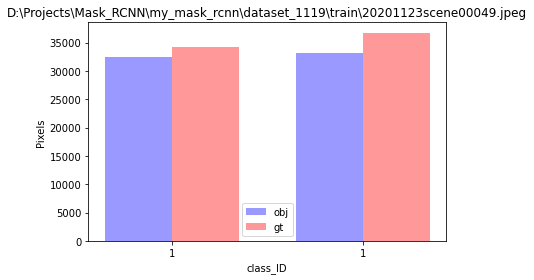

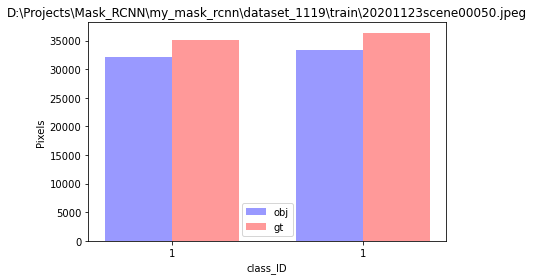

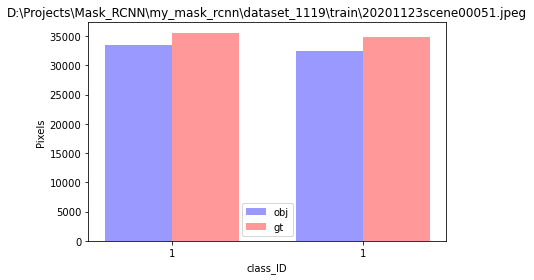

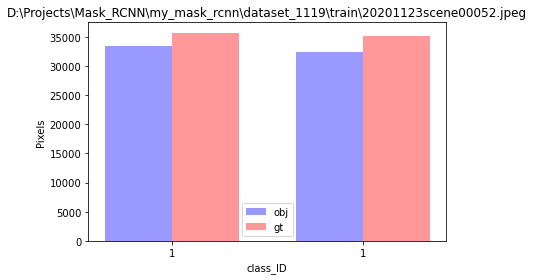

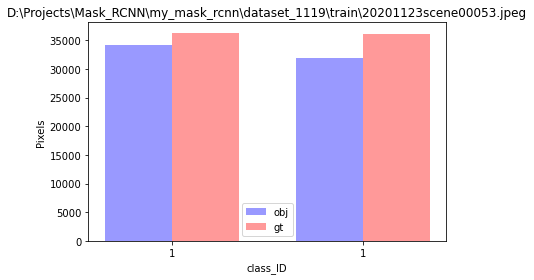

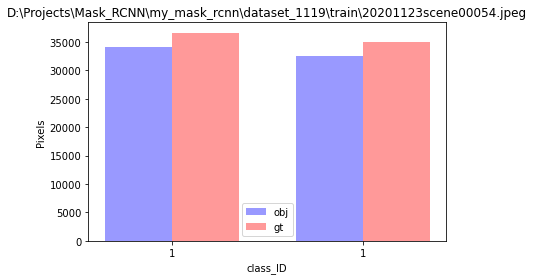

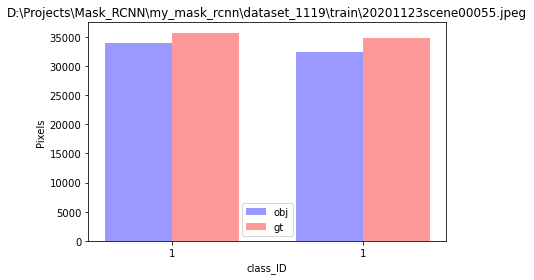

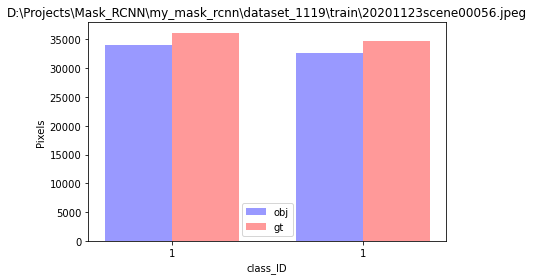

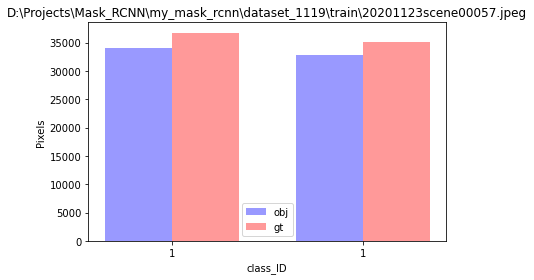

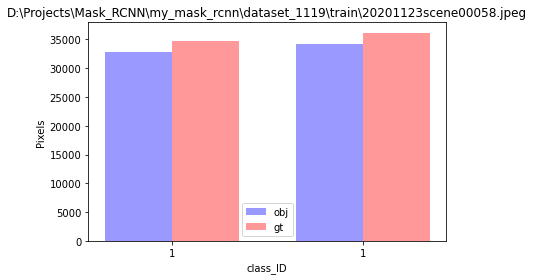

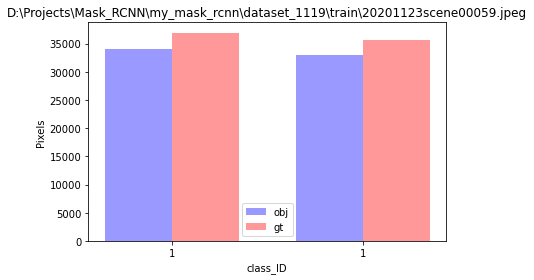

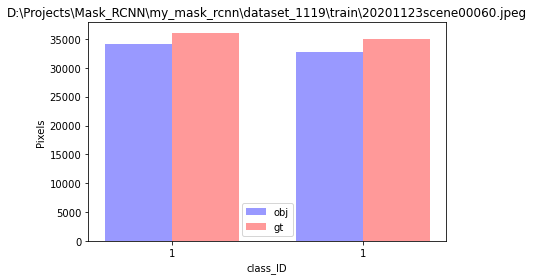

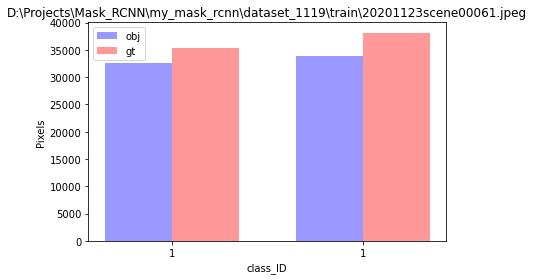

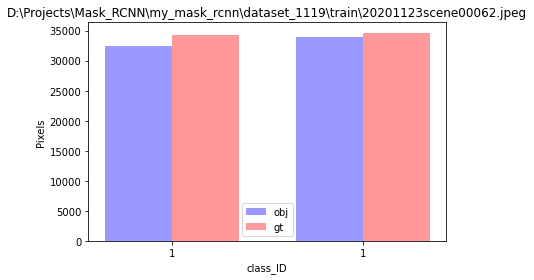

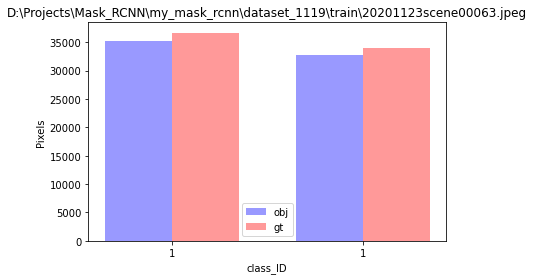

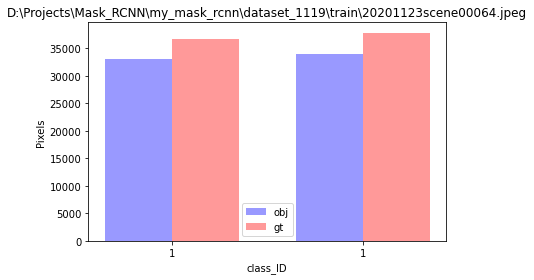

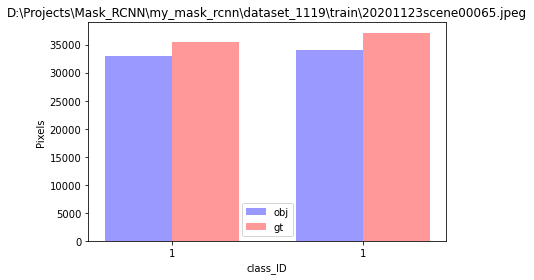

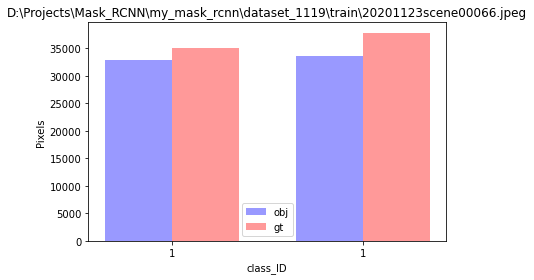

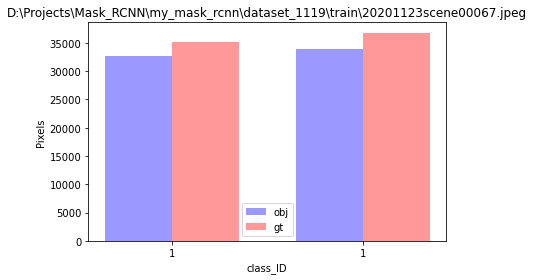

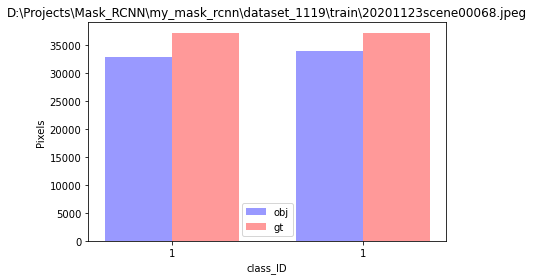

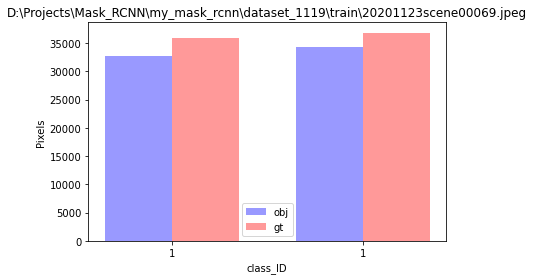

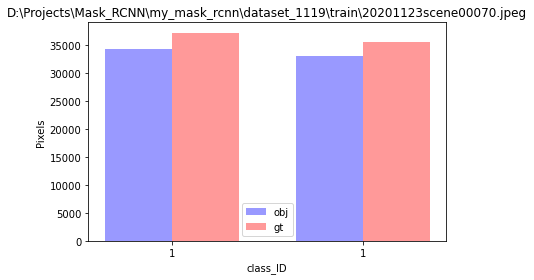

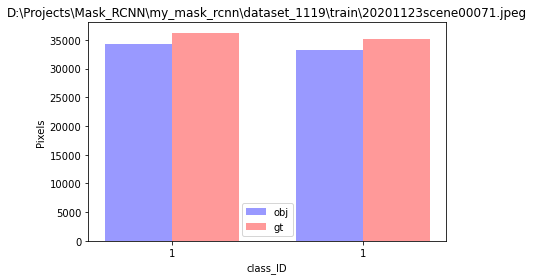

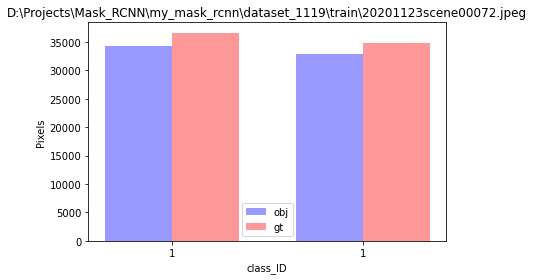

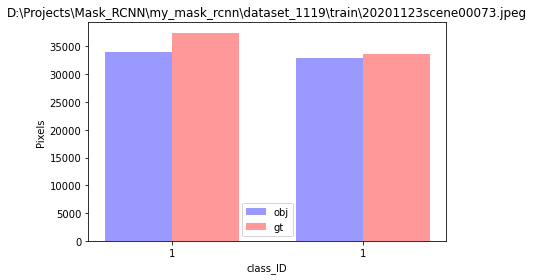

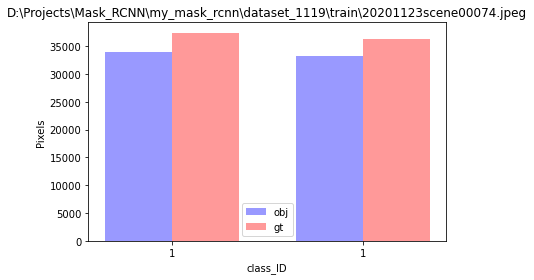

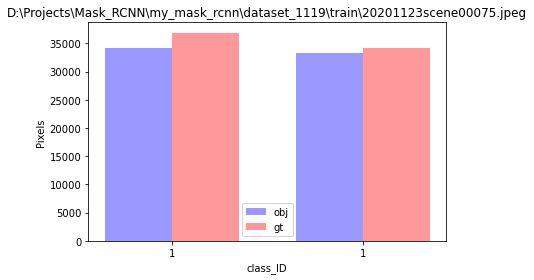

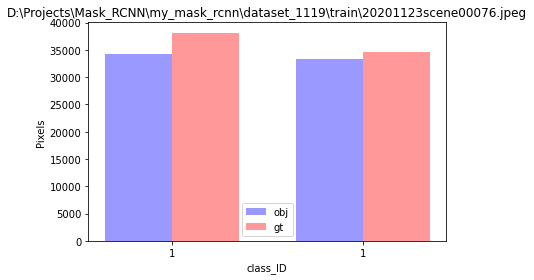

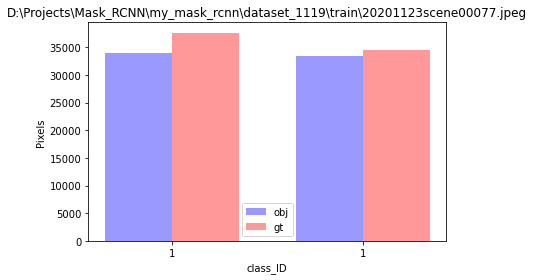

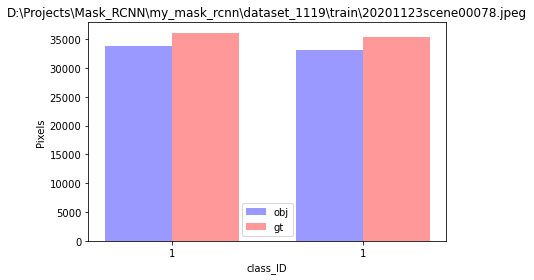

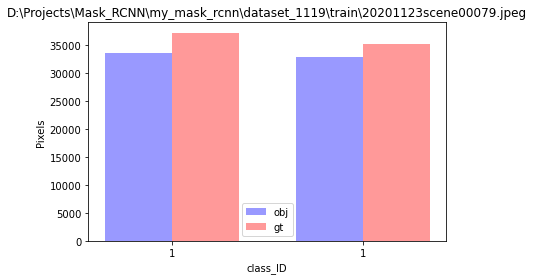

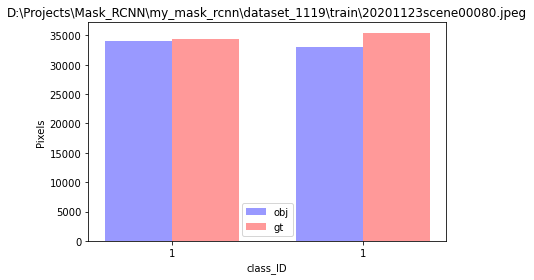

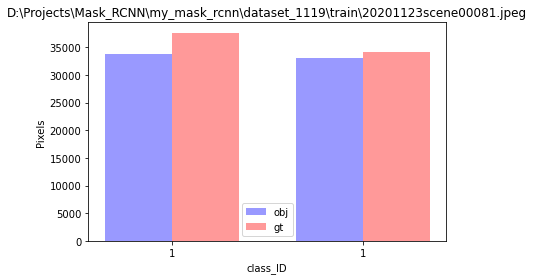

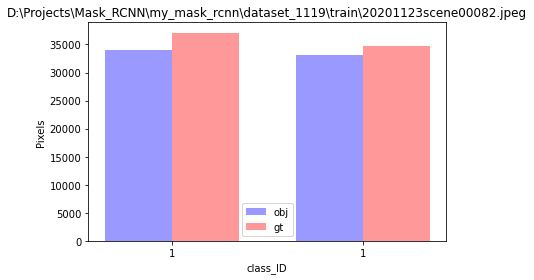

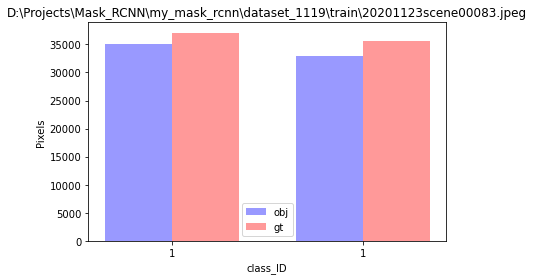

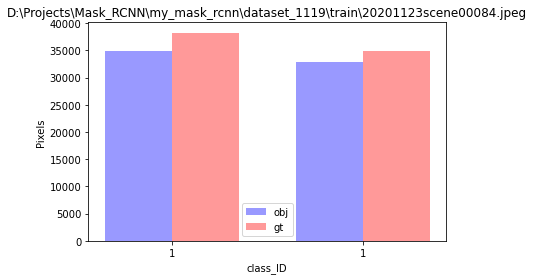

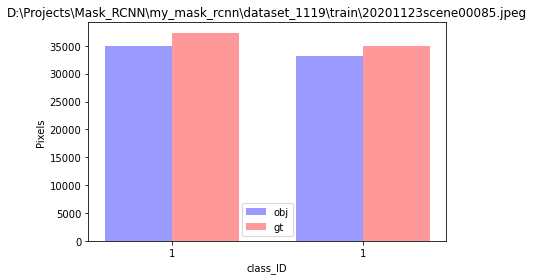

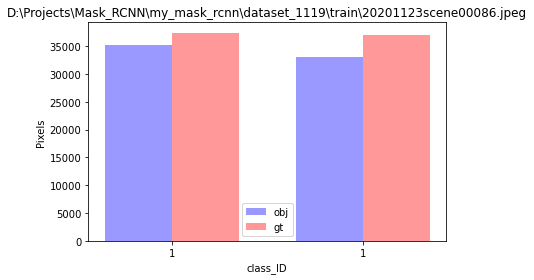

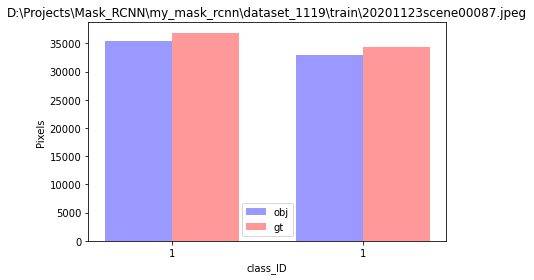

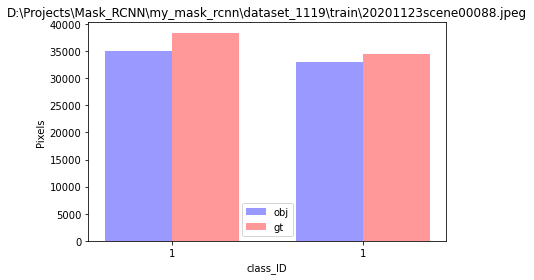

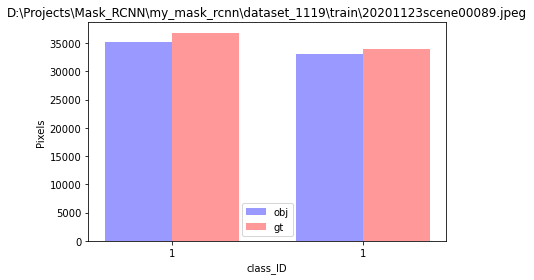

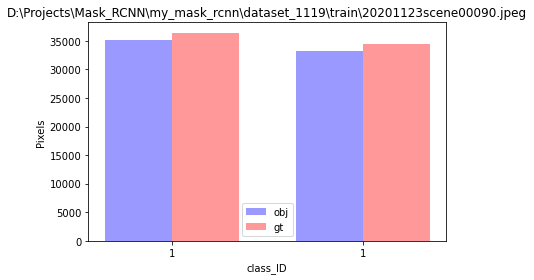

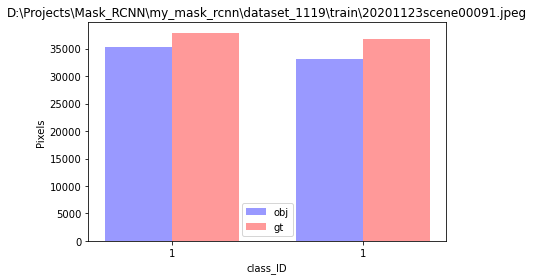

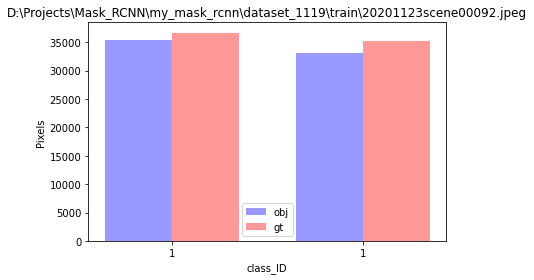

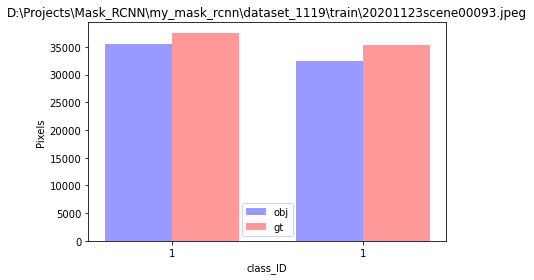

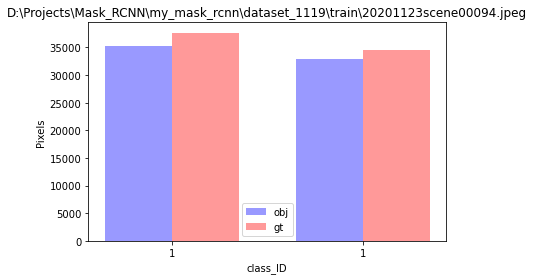

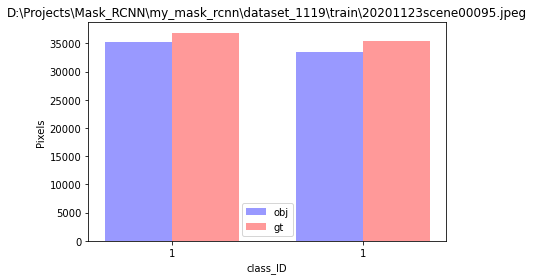

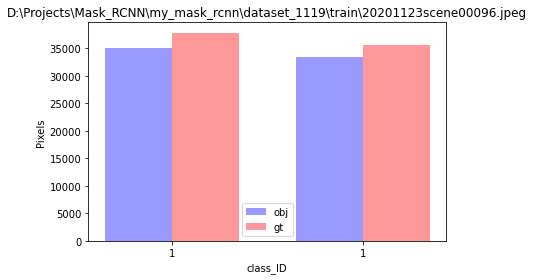

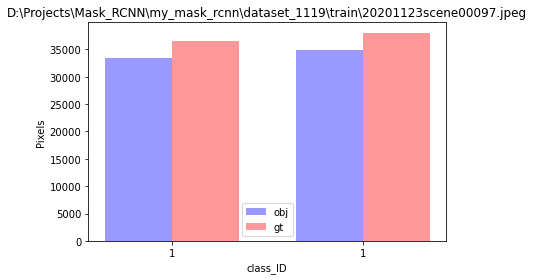

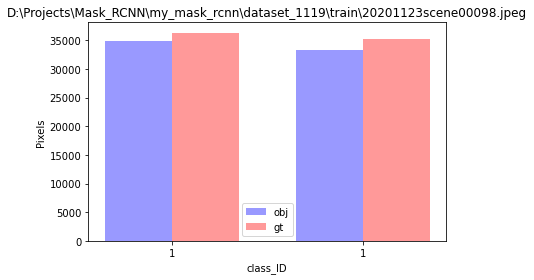

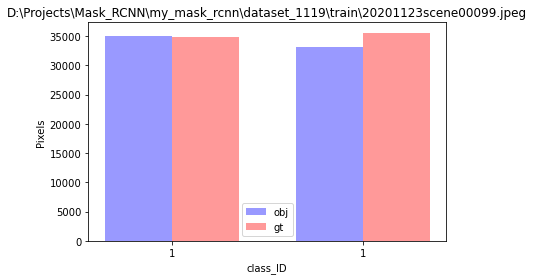

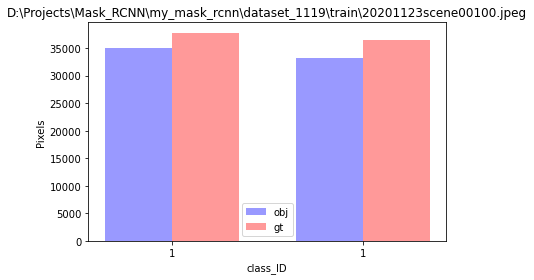

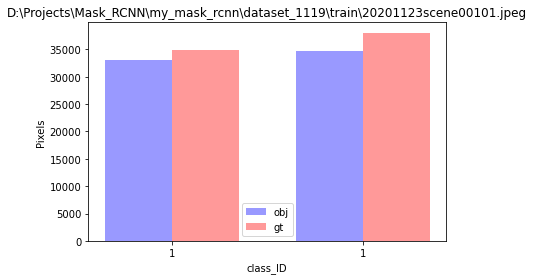

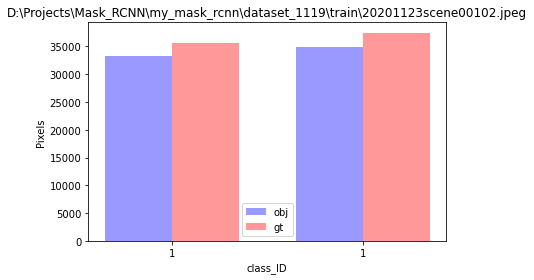

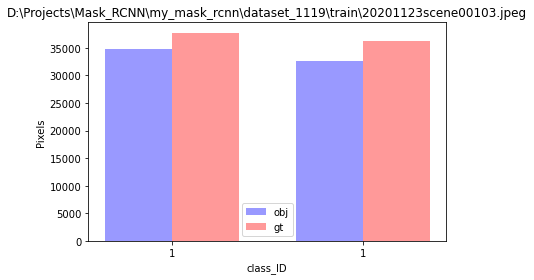

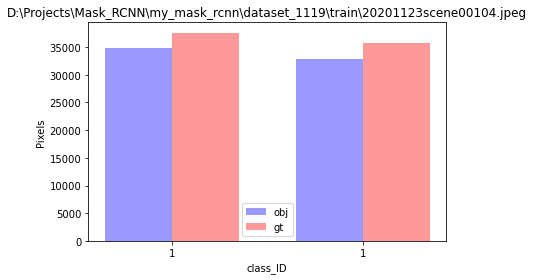

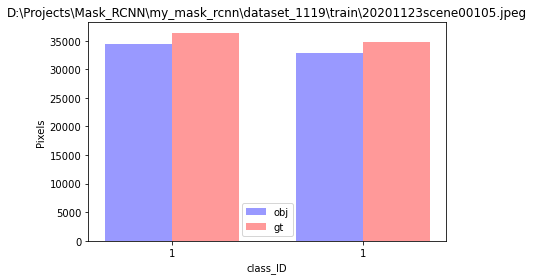

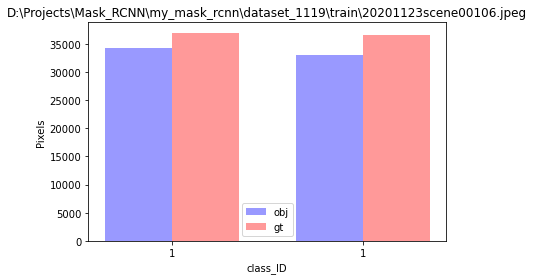

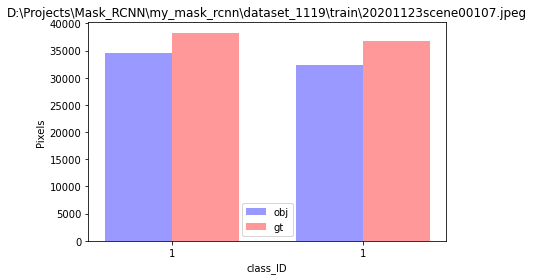

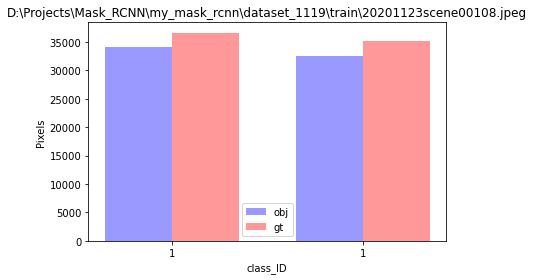

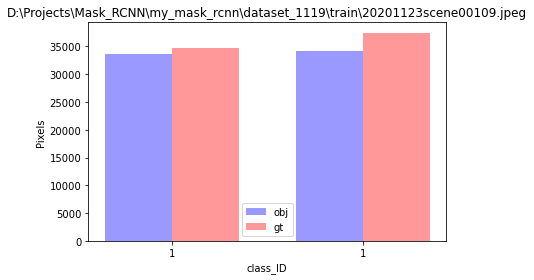

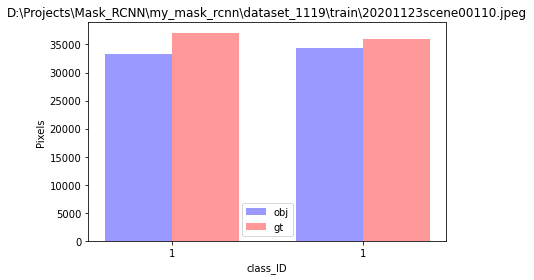

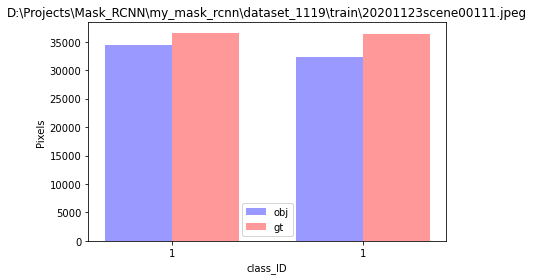

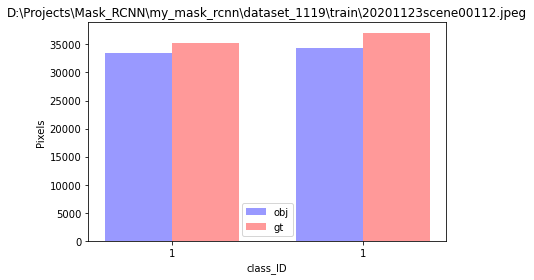

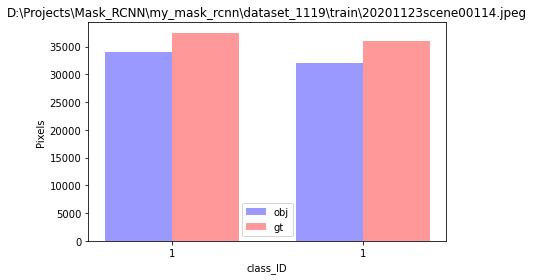

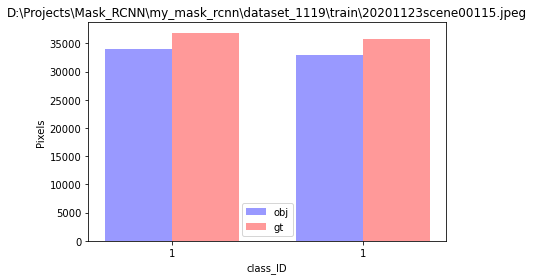

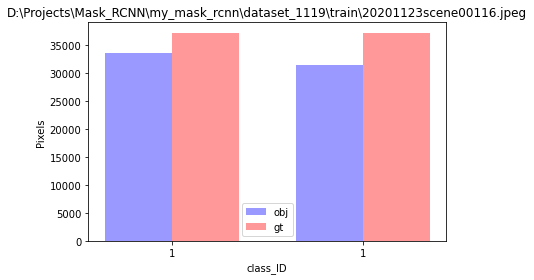

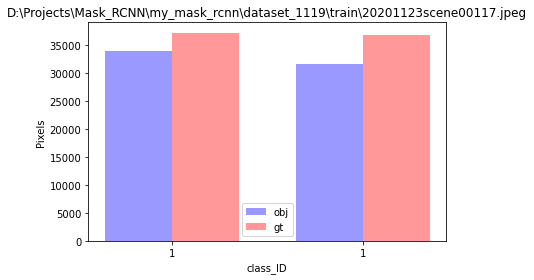

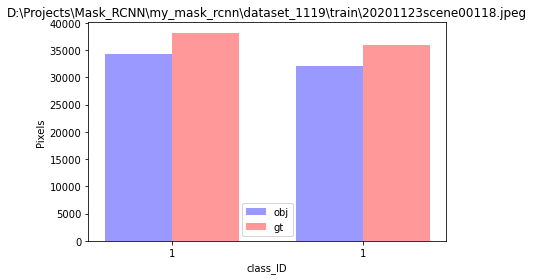

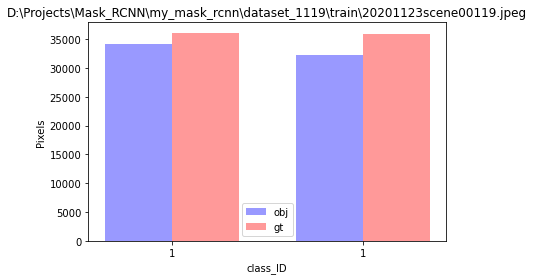

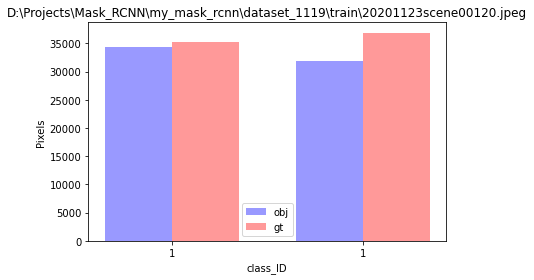

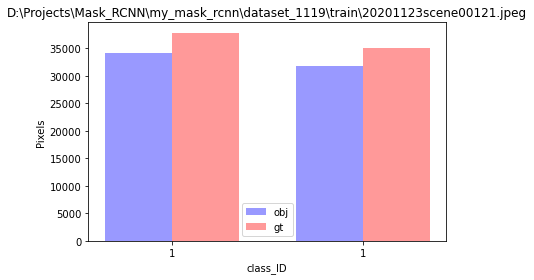

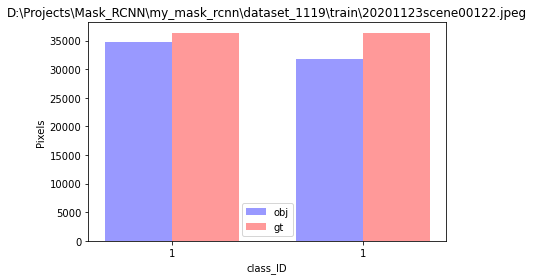

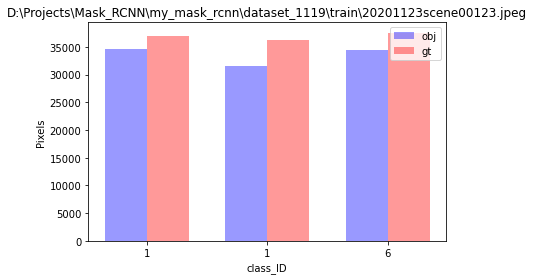

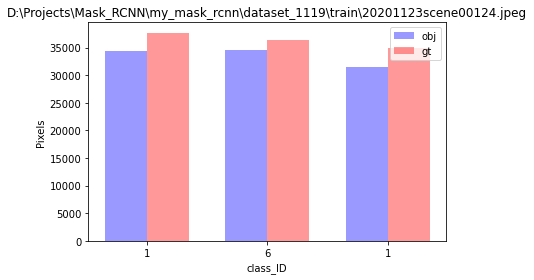

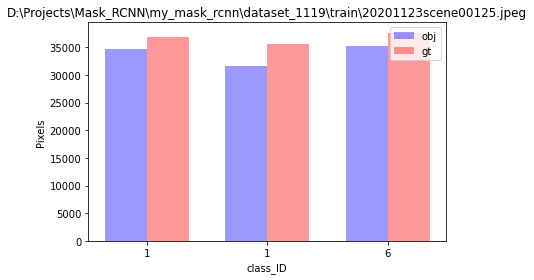

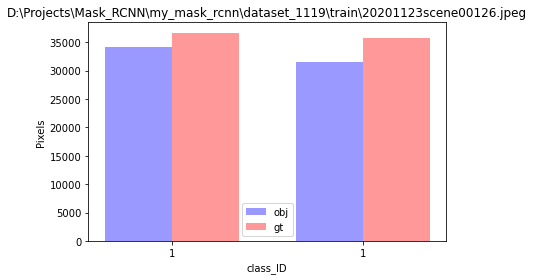

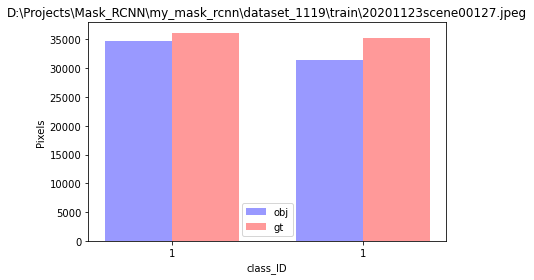

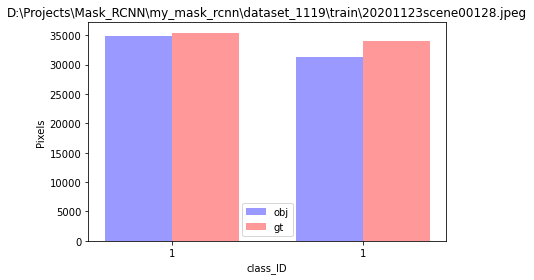

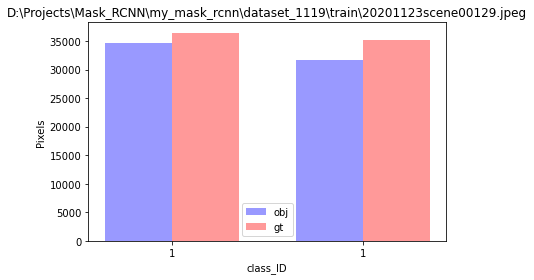

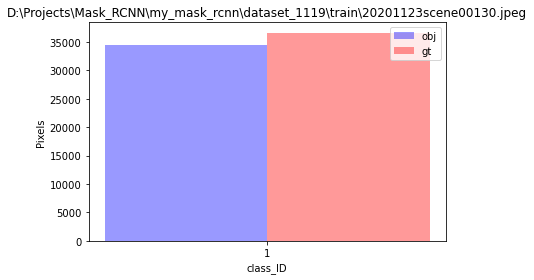

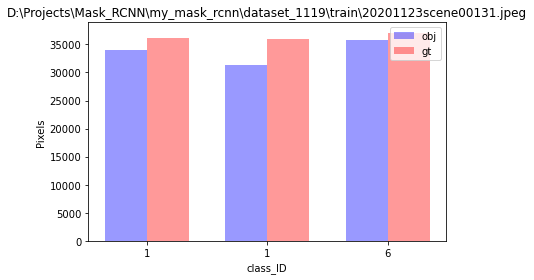

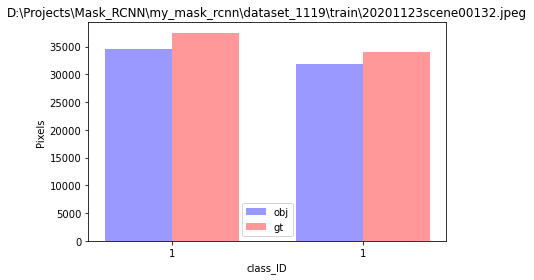

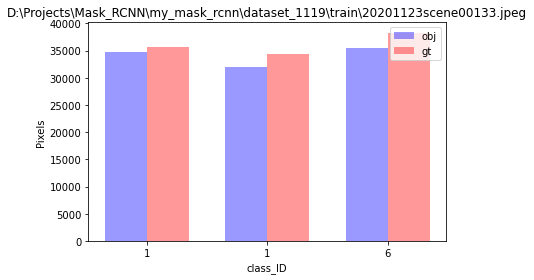

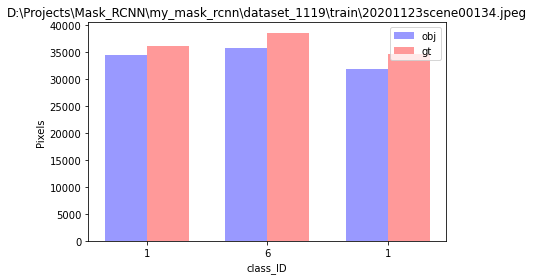

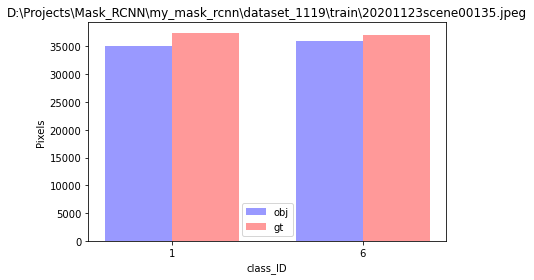

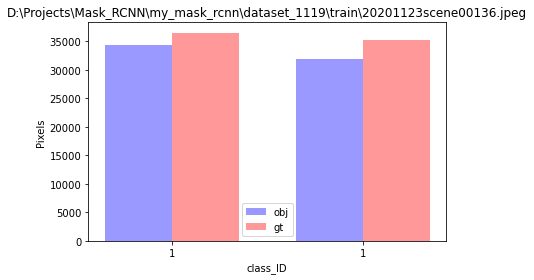

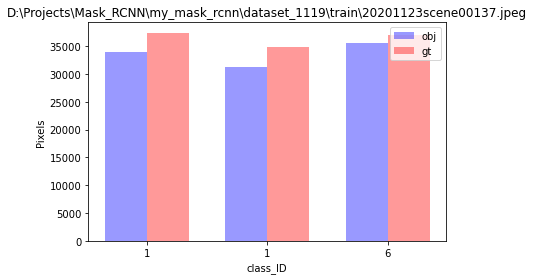

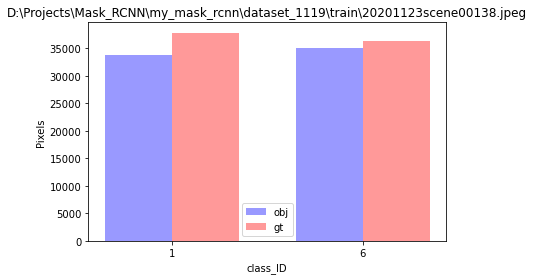

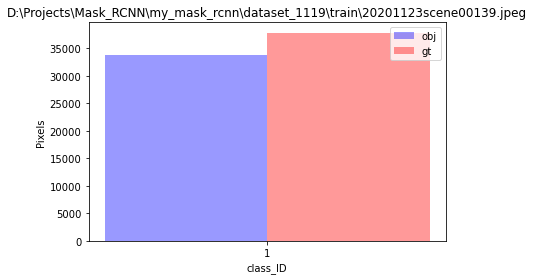

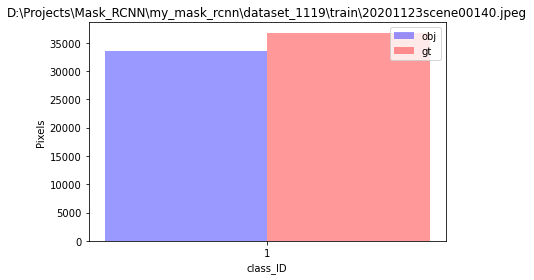

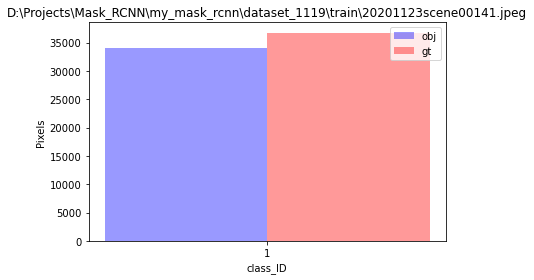

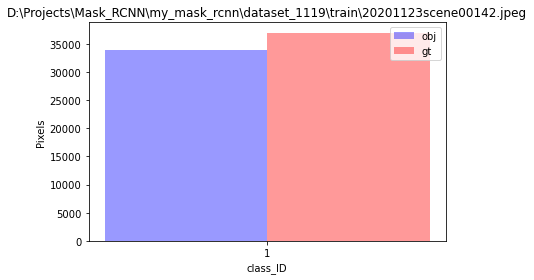

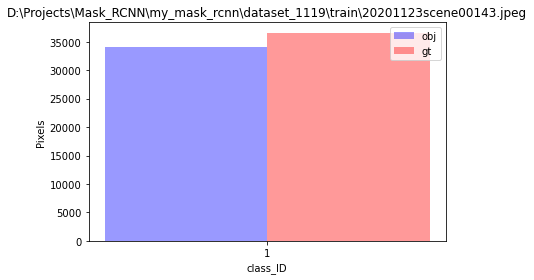

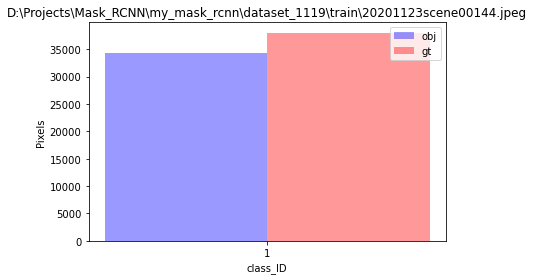

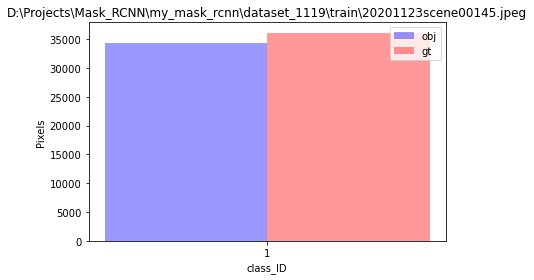

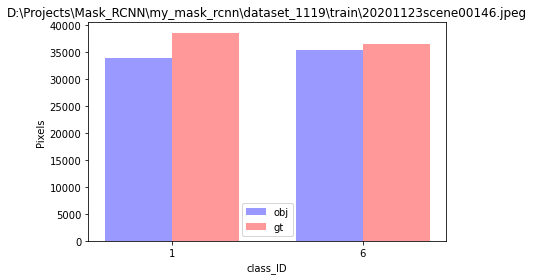

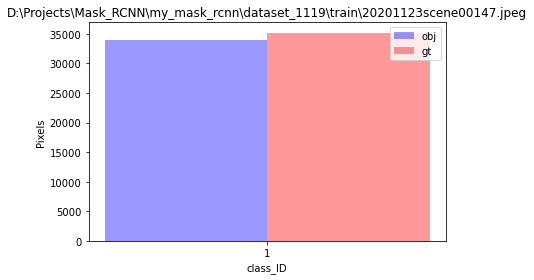

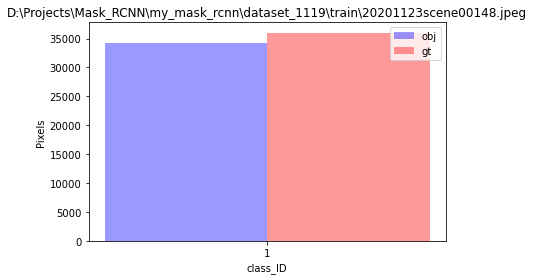

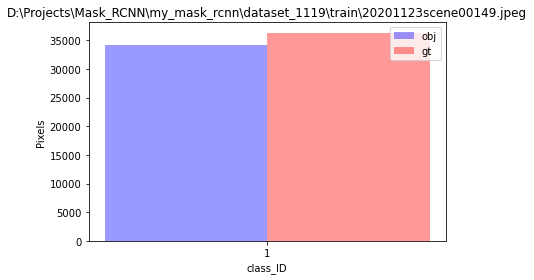

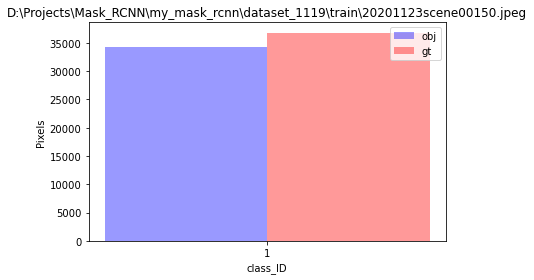

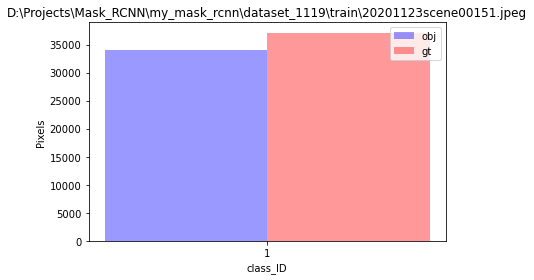

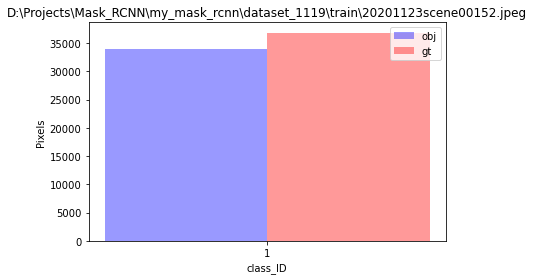

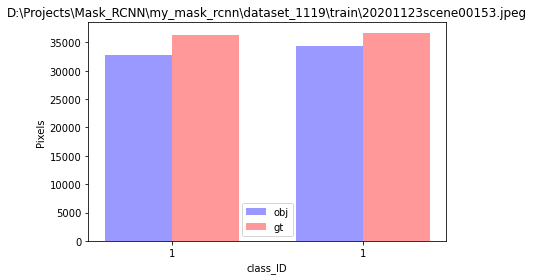

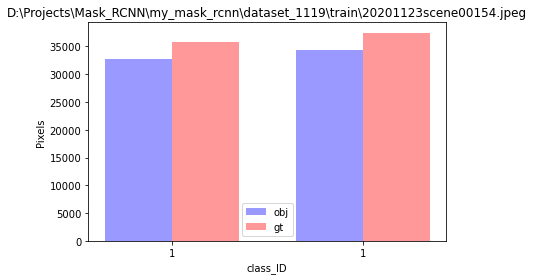

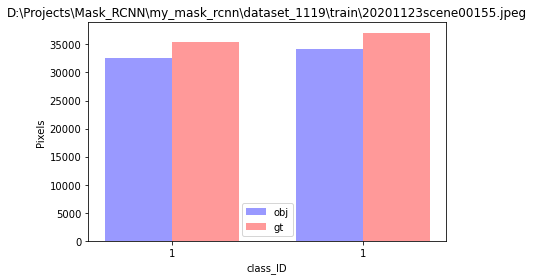

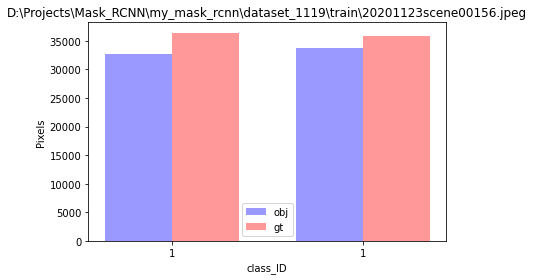

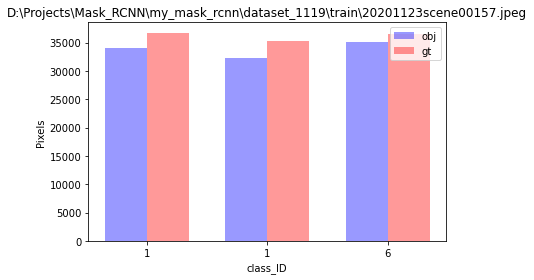

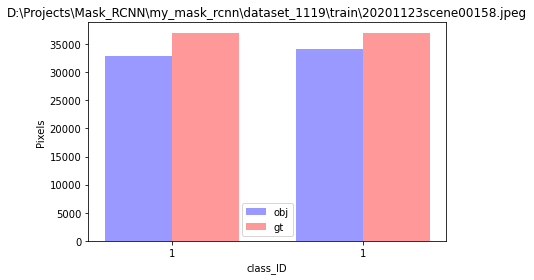

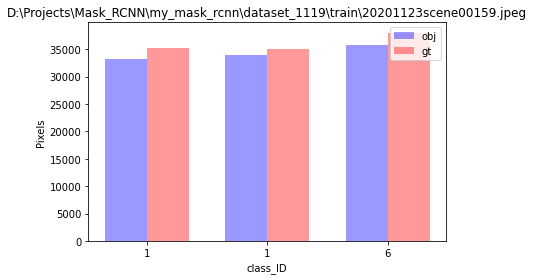

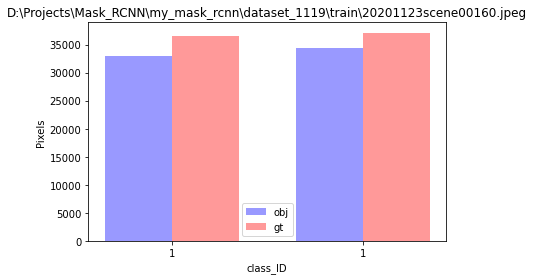

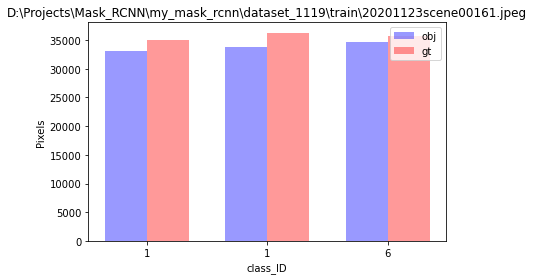

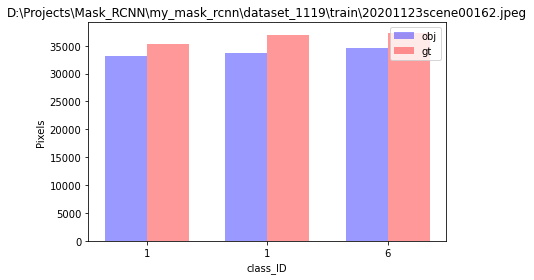

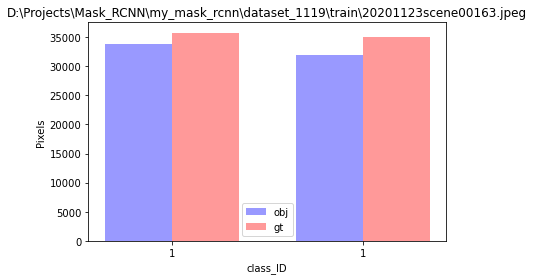

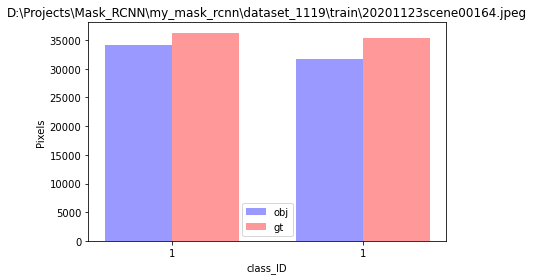

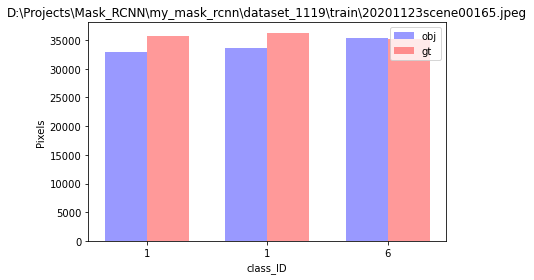

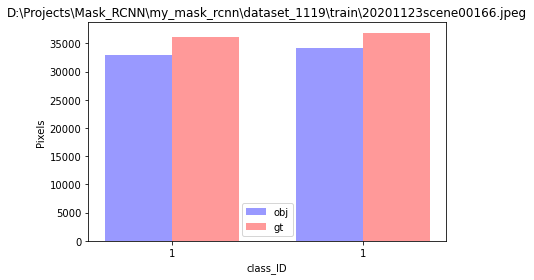

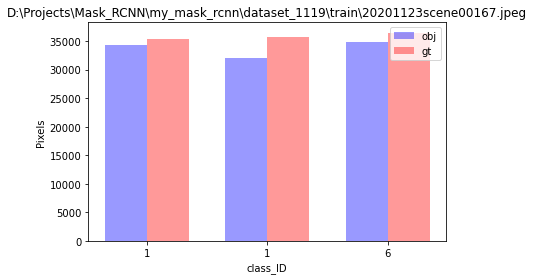

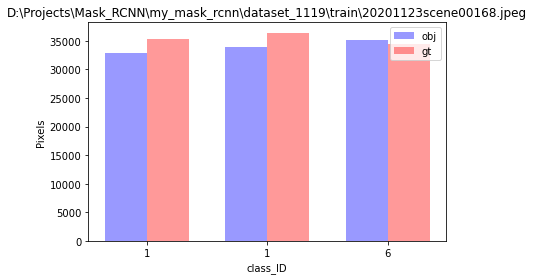

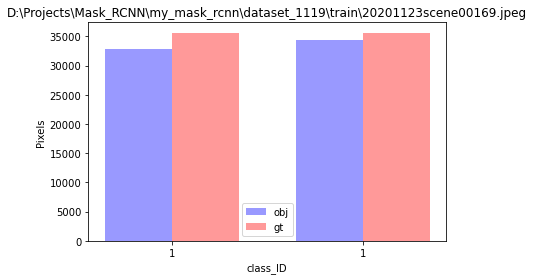

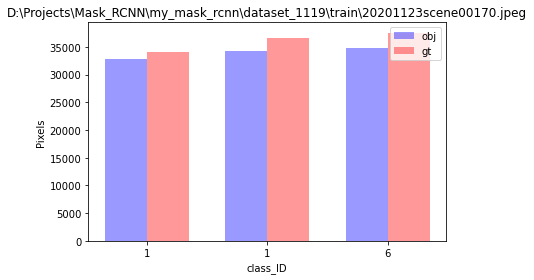

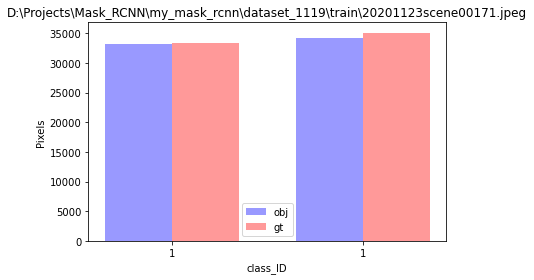

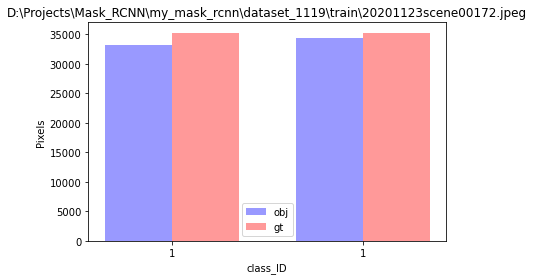

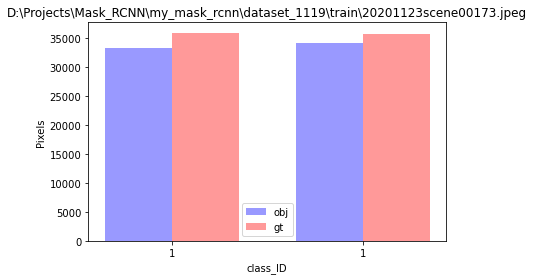

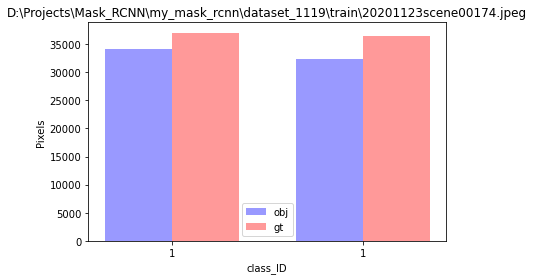

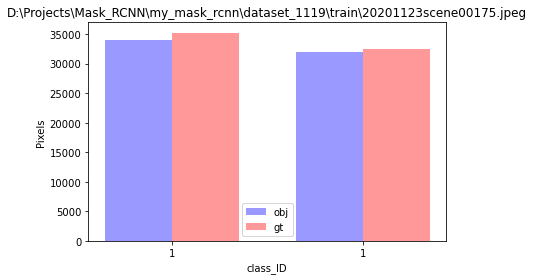

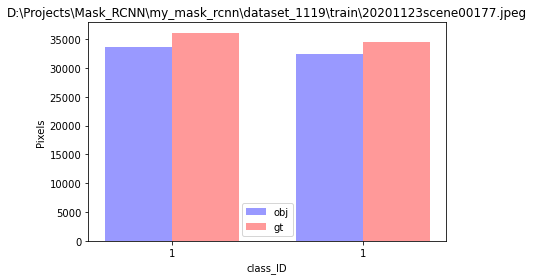

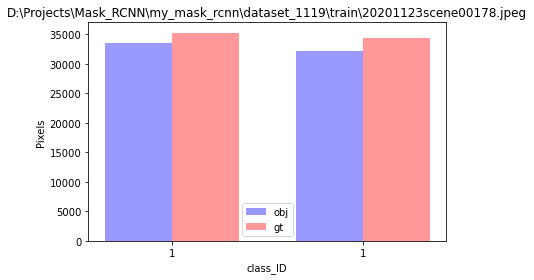

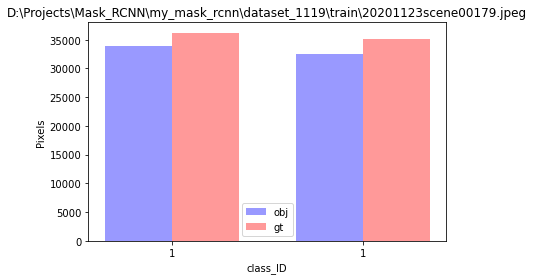

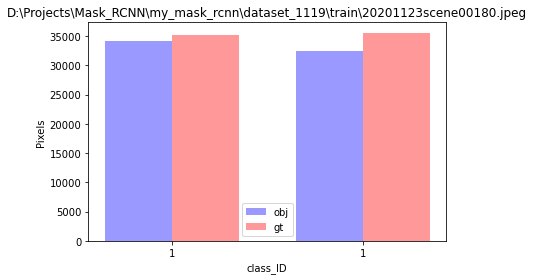

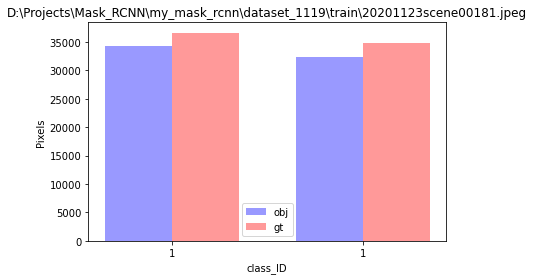

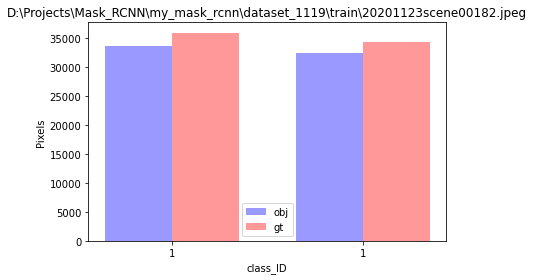

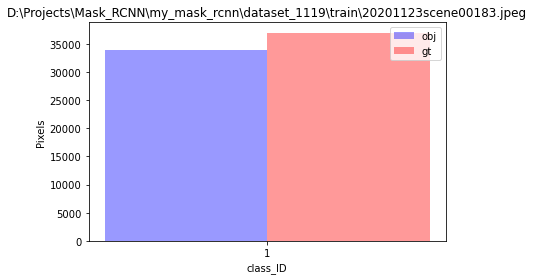

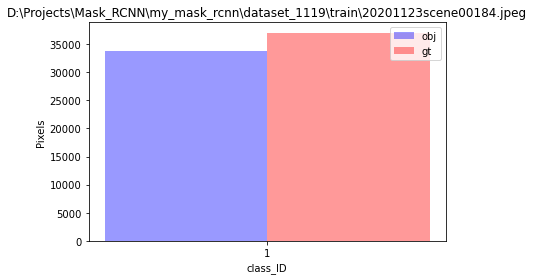

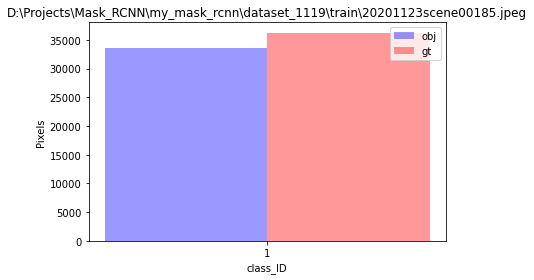

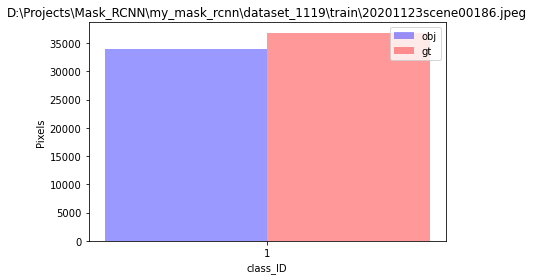

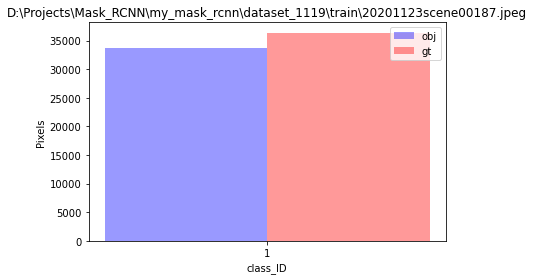

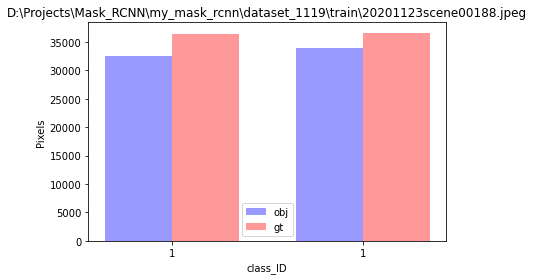

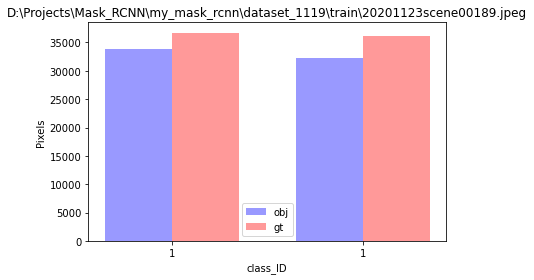

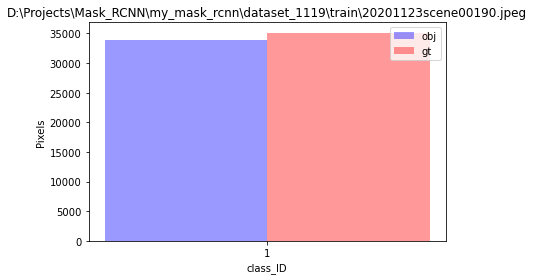

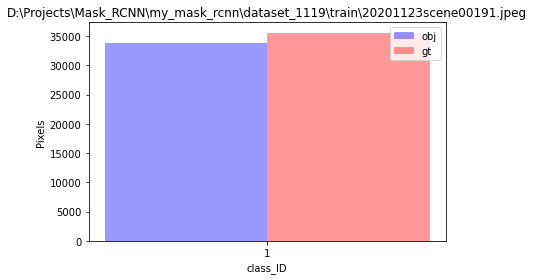

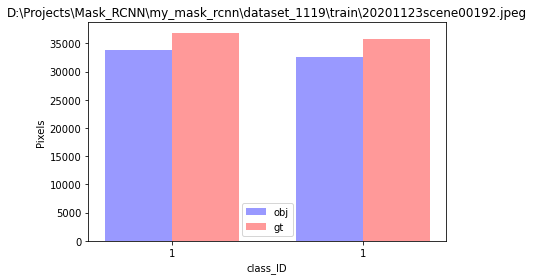

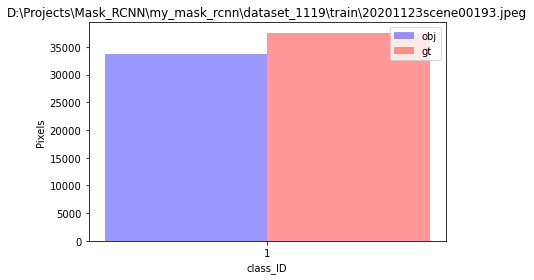

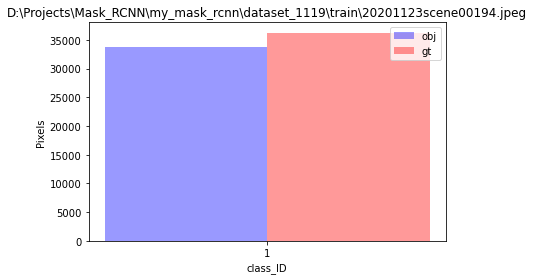

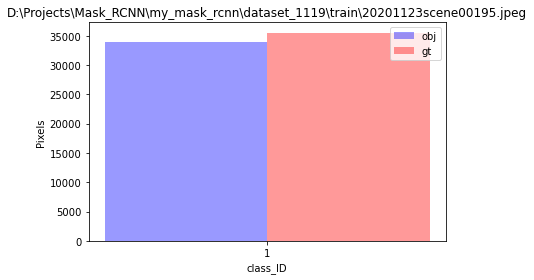

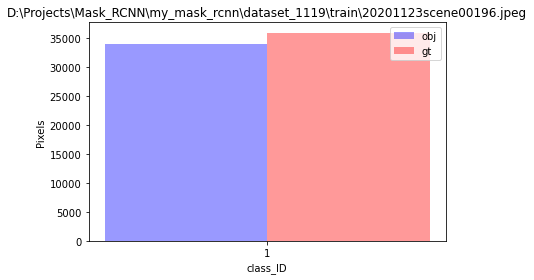

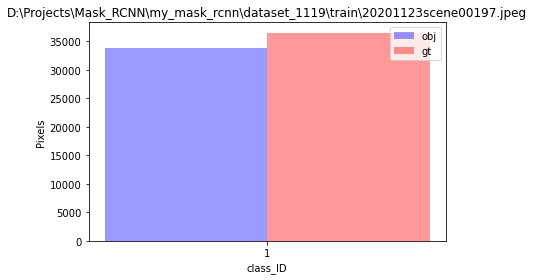

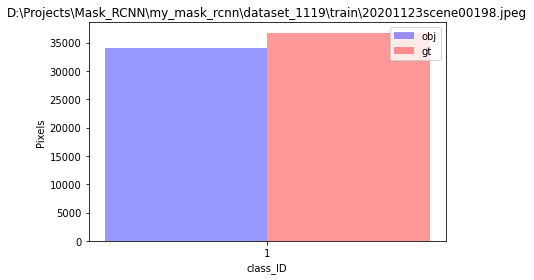

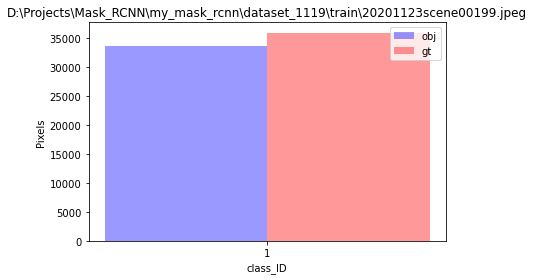

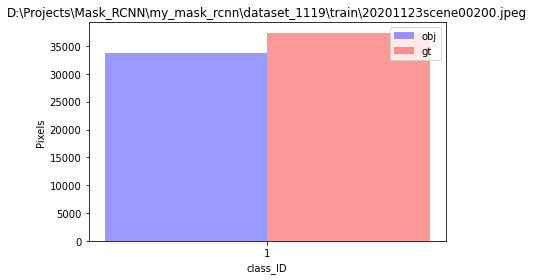

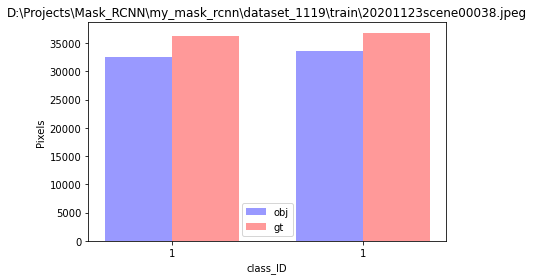

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
for target in gt_targets:
    gt_boxes = [tuple(x['bbox']) for x in target['gts']]
    gt_boxes = np.array(gt_boxes)
    obj_boxes = [tuple(x['bbox']) for x in target['objs']]
    obj_boxes = np.array(obj_boxes)
    overlaps = utils.compute_overlaps(obj_boxes, gt_boxes)
    #print(overlaps)
    obj_bars = []
    gt_bars = []
    index_bars = []
    n_groups = len(obj_boxes)
    for i in range(0, n_groups):
        w = np.where(overlaps == max(overlaps[i,:]))
        #print(w)
        # print(target['objs'][w[0][0]]['class_id'])
        # print(target['gts'][w[1][0]]['class_id'])
        obj = target['objs'][w[0][0]]
        gt = target['gts'][w[1][0]]
        obj_bars.append(obj['mask_area'])
        gt_bars.append(gt['mask_area'])
        index_bars.append(obj['class_id'])

    print(obj_bars)
    print(gt_bars)
    print(index_bars)
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    rects1 = ax.bar(index, obj_bars, bar_width,
                    alpha=opacity, color='b')

    rects2 = ax.bar(index + bar_width, gt_bars, bar_width,
                    alpha=opacity, color='r')

    ax.set_xlabel('class_ID')
    ax.set_ylabel('Pixels')
    ax.set_title(target['file'])
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(index_bars)
    ax.legend(labels=['obj', 'gt'])

    fig.tight_layout()

plt.show()


# 覆盖测试

人工不可能把所有目标的尺寸和宽高比逐个设置。现实做法是设置几个代表性的尺寸，如32、64、128。代表性的宽高比，如0.5、1、2

代表性数据不可能把所有目标都覆盖（IOU）

根据上述坐标图的数据分布情况，设置代表性尺寸、宽高比，在每个目标上标识最大的交并比（IOU）。

最大交并比（IOU）：理想值就是目标本身，但是以理想值为代表值，必然造成其它目标的交并比（IOU）下降。

三维坐标图：尺寸、宽高比、IOU

尺寸：锚框的正方形尺寸，应该从GT目标中挑选，把尺寸差值小于阈值的目标归为一组，将平均值作为锚框尺寸。目前网络设计，最多只有5个尺寸设置

宽高比：锚框的，也应该从GT目标中挑选。IoU：对所有目标的平均IoU，

理想状态是IOU值足够高（0~1），足以用于目标的过滤。

In [6]:
# 从小到大排序GT目标框尺寸

# 查找GT目标框尺寸的分组位置，即组内尺寸接近

# 代表性的尺寸、宽高比挑选（实验性）

人工设置代表值达到IOU理想状态也不现实。。。

怎么让计算机挑选代表值？